# Цель
Целью работы является определить оптимальный подход для процесса кластеризации для формирования клиентского профиля по факут выдочи кредита.

# Задачи
    1. Подготовка данных. Поиск лучше способа припроцессинга данных.
    2.  ВЫполнить кластризацию. Оценить качество кластеризаии.
    3. Сформировать клинетский профиль по выдаче крида.

В данной работе будут использовать два алгоритма AgglomerativeClustering и KMeans. Оценка качества будет производиться метрикой silhouette_score. Будет установлено оптимальное число компанент для PCA и оптимальное число кластеров для каждого алгоритма.
Также будет проведено два подхода (выполняются парарлельно и сравниваются): А приминяется PolynomialFeatures, B PolynomialFeatures не применяется к данным. 

#### Чем обосновывается не приминение PolynomialFeatures? 
1. Приминить PolynomialFeatures ко всем данным лично на моём компьютере нет возможности. Выскакивает ошибка о недостаточности памяти.
2. Проанлезировав PolynomialFeatures как инструмент можно сделать вывод, что он создает дополнительные "связи" между признаками. применяя этот иснтумент для отдельного пары призакнво (в случае А применяется он к не категориальынм данным) и в сочетании с тем, что категориальные признаки предствлены через one-hot encoding, то наличие такого большого признакового пространва создает вероятнсоть создания большого числа отдельных не имеющих информативности. 


In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
link = r"D:\Datasets\credit\credit_train.csv"
df = pd.read_csv(link, sep=';')
df.head()

client_id gender   age marital_status job_position credit_sum  \
0          1      M   NaN            NaN          UMN   59998,00   
1          2      F   NaN            MAR          UMN   10889,00   
2          3      M  32.0            MAR          SPC   10728,00   
3          4      F  27.0            NaN          SPC   12009,09   
4          5      M  45.0            NaN          SPC        NaN   

   credit_month  tariff_id score_shk education        living_region  \
0            10        1.6       NaN       GRD   КРАСНОДАРСКИЙ КРАЙ   
1             6        1.1       NaN       NaN               МОСКВА   
2            12        1.1       NaN       NaN      ОБЛ САРАТОВСКАЯ   
3            12        1.1       NaN       NaN    ОБЛ ВОЛГОГРАДСКАЯ   
4            10        1.1  0,421385       SCH  ЧЕЛЯБИНСКАЯ ОБЛАСТЬ   

   monthly_income  credit_count  overdue_credit_count open_account_flg,,  
0         30000.0           1.0                   1.0                 0,  
1             NaN           2.0                   0.0                 0,  
2             NaN           5.0                   0.0                 0,  
3             NaN           2.0                   0.0                 0,  
4             NaN           1.0                   0.0                 0,

In [3]:
df.rename(columns={'open_account_flg,,':'open_account_flg'}, inplace=True)
df.drop(inplace=True, columns='client_id')

### living_region

In [4]:
print('living_region:\t', df['living_region'].nunique())

living_region:	 301


In [5]:
pd.options.display.max_rows = 310
regions = df['living_region'].unique()
regions = pd.Series(data=regions, name='regions', index=regions)

In [6]:
list_uniqie_words_from_regions = {re.sub(pattern=r"[\/\/\\\.,(0)\-']",
                                         repl='',
                                         string=j) for www in map(lambda x: x.split(' ') if type(x) is not float else [], regions.values) for j in www}

In [7]:
# Город Санкт-Петербург - регион 98
print(list_uniqie_words_from_regions)
stop_words = ['АО', 'КРАЙ', 'РЕСПУБЛИКА', 'Г', 'АОБЛ', 'ОКРУГ', 'ЭЛ', 'ОБЛ', 'РЕСП']

{'', 'ТАМБОВСКАЯ', 'РОССИЯ', 'ЧИТИНСКАЯ', 'ТОМСКАЯ', 'РН', 'СЕВ', 'ПЕРМСКИЙ', 'РОСТОВСКАЯ', 'ИРКУТСКАЯ', 'КРАСНОЯРСКИЙ', 'БАШКОРТОСТАН', 'ИВАНОВСКАЯ', 'РЕСПУБЛИКАТАТАРСТАН', 'Г', 'БРЯНСКАЯ', 'ЛИПЕЦКАЯ', 'ДАЛЬНИЙ', 'ФЕДЕРАЛЬНЫЙ', 'ЭЛ', 'ЯКУТИЯ', 'БРЯНСКИЙ', 'КРАСНОДАРСКИЙ', 'ЮГРА', 'ЭВЕНКИЙСКИЙ', 'ОМСКАЯ', 'АВТОНОМНЫЙ', 'ПЕНЗЕНСКАЯ', 'ВОРОНЕЖСКАЯ', 'УДМУРТСКАЯ', 'ОБЛСАРАТОВСКАЯ', 'КОСТРОМСКАЯ', 'ВОЛГОГРАДСКАЯ', 'Ю', 'ЧУВАШСКАЯ', 'ОБЛМОСКОВСКАЯ', 'КИРОВСКАЯ', 'АМУРСКАЯ', 'МОРДОВИЯ', 'ЯМАЛОНЕНЕЦКИЙ', 'ЗАБАЙКАЛЬСКИЙ', 'ОБЛАСТЬ', 'ТУЛЬСКАЯ', 'ОБЛРОСТОВСКАЯ', 'РЕСПБАШКОРТОСТАН', 'ЧЕЧЕНСКАЯ', 'КАРАЧАЕВОЧЕРКЕССКАЯ', 'ПЕРМСКАЯ', 'ОБЛ', 'РЕСП', 'ОБЛНИЖЕГОРОДСКАЯ', 'МОСКВОСКАЯ', 'ВОСТОК', 'ТЮМЕНСКАЯ', 'АЛТАЙСКИЙ', 'ХАБАРОВСКИЙ', 'ТАТАРСТАН', 'АВТОНОМНАЯ', 'АЛАНИЯ', 'КРАЙ', 'МАРИЙ', 'ПРИВОЛЖСКИЙ', '98', 'КЕМЕРОВСКАЯ', 'КАЛУЖСКАЯ', 'НОВОСИБИРСКАЯ', 'ЕВРЕЙСКАЯ', 'РЕСПУБЛИКА', 'МАГАДАНСКАЯ', 'ОРЁЛ', 'САРАТОВСКАЯ', 'АДЫГЕЯ', 'РЯЗАНСКАЯ', 'ХАКАСИЯ', 'САХА', 'ТЫВА', 'САХАЛИНСКАЯ', 'КРАЙПЕРМСКИЙ', 'ОРЕНБ

In [8]:
def del_words_regions(arg):
    arg = re.sub(r"[\/\/\\\.,(0)\-']", ' ', str(arg))
    words = re.split(' ', arg)
    new_words = []
    for word in words:
        if word not in stop_words:
            new_words.append(word)
    return ' '.join(new_words)

In [9]:
del_words_regions('ОБЛ САРАТОВСКАЯ')

'САРАТОВСКАЯ'

In [10]:
regions = regions.map(del_words_regions)

In [11]:
regions['РЕСП. САХА (ЯКУТИЯ)'] = 'САХА' 
regions['ТЮМЕНСКАЯ ОБЛАСТЬ'] = 'ТЮМЕНСКАЯ'
regions['ТВЕРСКАЯ ОБЛАСТЬ'] = 'ТВЕРСКАЯ'
regions['ЯРОСЛАВСКАЯ ОБЛАСТЬ'] = 'ЯРОСЛАВСКАЯ'
regions['РЕСП ЧЕЧЕНСКАЯ'] = 'ЧЕЧЕНСКАЯ'
regions['ТУЛЬСКАЯ ОБЛАСТЬ'] = 'ТУЛЬСКАЯ'
regions['СМОЛЕНСКАЯ ОБЛАСТЬ'] = 'СМОЛЕНСКАЯ'
regions['САМАРСКАЯ ОБЛАСТЬ'] = 'САМАРСКАЯ'
regions['ОРЛОВСКАЯ ОБЛАСТЬ'] = 'ОРЛОВСКАЯ'
regions['ТОМСКАЯ ОБЛАСТЬ'] = 'ТОМСКАЯ'
regions['САРАТОВСКАЯ ОБЛАСТЬ'] = 'САРАТОВСКАЯ'
regions['АО ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - Ю'] = 'ХАНТЫ МАНСИЙСКИЙ'
regions['БАШКОРТОСТАН'] = 'БАШКОРТОСТАН'
regions['ПСКОВСКАЯ ОБЛАСТЬ'] = 'ПСКОВСКАЯ'
regions['ВОЛОГОДСКАЯ ОБЛАСТЬ'] = 'ВОЛОГОДСКАЯ'
regions['САХА /ЯКУТИЯ/ РЕСП'] = 'САХА' 
regions['ОМСКАЯ ОБЛАСТЬ'] = 'ОМСКАЯ'
regions['АРХАНГЕЛЬСКАЯ ОБЛАСТЬ'] = 'АРХАНГЕЛЬСКАЯ'
regions['РЕСП СЕВЕРНАЯ ОСЕТИЯ - АЛАНИЯ'] = 'СЕВЕРНАЯ ОСЕТИЯ АЛАНИЯ'
regions['ПЕНЗЕНСКАЯ ОБЛАСТЬ'] = 'ПЕНЗЕНСКАЯ'
regions['УЛЬЯНОВСКАЯ ОБЛАСТЬ'] = 'УЛЬЯНОВСКАЯ'
regions['САХАЛИНСКАЯ ОБЛАСТЬ'] = 'САХАЛИНСКАЯ'
regions['ЧУВАШСКАЯ РЕСПУБЛИКА - ЧУВАШИЯ'] = 'ЧУВАШСКАЯ'
regions['МОСКОВСКАЯ ОБЛАСТЬ'] = 'МОСКОВСКАЯ'
regions['ОРЕНБУРГСКАЯ ОБЛАСТЬ'] = 'ОРЕНБУРГСКАЯ'
regions['РЯЗАНСКАЯ ОБЛАСТЬ'] = 'РЯЗАНСКАЯ'
regions['ТАМБОВСКАЯ ОБЛАСТЬ'] = 'ТАМБОВСКАЯ'
regions['АСТРАХАНСКАЯ ОБЛАСТЬ'] = 'АСТРАХАНСКАЯ'
regions['СЕВЕРНАЯ ОСЕТИЯ - АЛАНИЯ РЕСП'] = 'СЕВЕРНАЯ ОСЕТИЯ АЛАНИЯ'
regions['ЧУВАШСКАЯ - ЧУВАШИЯ РЕСП'] = 'ЧУВАШСКАЯ'
regions['РЕСП САХА /ЯКУТИЯ/'] = 'САХА' 
regions['ЛЕНИНГРАДСКАЯ ОБЛАСТЬ'] = 'ЛЕНИНГРАДСКАЯ'
regions['МУРМАНСКАЯ ОБЛАСТЬ'] = 'МУРМАНСКАЯ'
regions['КЕМЕРОВСКАЯ ОБЛАСТЬ'] = 'КЕМЕРОВСКАЯ'
regions['КУРГАНСКАЯ ОБЛАСТЬ'] = 'КУРГАНСКАЯ'
regions['ВОЛГОГРАДСКАЯ ОБЛАСТЬ'] = 'ВОЛГОГРАДСКАЯ'
regions['СЕВ. ОСЕТИЯ - АЛАНИЯ'] = 'СЕВЕРНАЯ ОСЕТИЯ АЛАНИЯ'
regions['БЕЛГОРОДСКАЯ ОБЛАСТЬ'] = 'БЕЛГОРОДСКАЯ'
regions['ВЛАДИМИРСКАЯ ОБЛАСТЬ'] = 'ВЛАДИМИРСКАЯ'
regions['ЧУВАШИЯ ЧУВАШСКАЯ РЕСПУБЛИКА -'] = 'ЧУВАШСКАЯ'  
regions['АМУРСКАЯ ОБЛАСТЬ'] = 'АМУРСКАЯ'
regions['РЕСПУБЛИКАТАТАРСТАН'] = 'ТАТАРСТАН'
regions['РОССИЯ'] = None
regions['ВОРОНЕЖСКАЯ ОБЛАСТЬ'] = 'ВОРОНЕЖСКАЯ'
regions['БРЯНСКАЯ ОБЛАСТЬ'] = 'БРЯНСКАЯ'
regions['98'] = 'САНКТ ПЕТЕРБУРГ'
regions['МЫТИЩИНСКИЙ Р-Н'] = 'МЫТИЩИНСКИЙ'
regions['ИВАНОВСКАЯ ОБЛАСТЬ'] = 'ИВАНОВСКАЯ'
regions['КАЛУЖСКАЯ ОБЛАСТЬ'] = 'КАЛУЖСКАЯ'
regions['КОСТРОМСКАЯ ОБЛАСТЬ'] = 'КОСТРОМСКАЯ'
regions['ЛИПЕЦКАЯ ОБЛАСТЬ'] = 'ЛИПЕЦКАЯ'
regions['ЕВРЕЙСКАЯ АВТОНОМНАЯ'] = 'ЕВРЕЙСКАЯ'
regions['КАМЧАТСКАЯ ОБЛАСТЬ'] = 'КАМЧАТСКАЯ'
regions['НОВОСИБИРСКАЯ ОБЛАСТЬ'] = 'НОВОСИБИРСКАЯ'
regions['НОВГОРОДСКАЯ ОБЛАСТЬ'] = 'НОВГОРОДСКАЯ'
regions['ГУСЬ-ХРУСТАЛЬНЫЙ Р-Н'] = 'ГУСЬ ХРУСТАЛЬНЫЙ'
regions['КИРОВСКАЯ ОБЛАСТЬ'] = 'КИРОВСКАЯ'
regions['74'] = 'АДЫГЕЯ'
regions['МАГАДАНСКАЯ ОБЛАСТЬ'] = 'МАГАДАНСКАЯ'
regions['САХА /ЯКУТИЯ/'] = 'САХА'
regions['Г.ОДИНЦОВО МОСКОВСКАЯ ОБЛ'] = 'МОСКОВСКАЯ'
regions['РЕСП ЧУВАШСКАЯ - ЧУВАШИЯ'] = 'ЧУВАШСКАЯ'
regions['КУРСКАЯ ОБЛАСТЬ'] = 'КУРСКАЯ'
regions['КАЛИНИНГРАДСКАЯ ОБЛ.'] = 'КАЛИНИНГРАДСКАЯ'
regions['ЧЕЛЯБИНСКАЯ ОБЛАСТЬ'] = 'ЧЕЛЯБИНСКАЯ'
regions['РЕСП. БАШКОРТОСТАН'] = 'БАШКОРТОСТАН'
regions['ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - ЮГРА'] = 'ХАНТЫ МАНСИЙСКИЙ'
regions['ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ'] = 'ПРИВОЛЖСКИЙ'
regions['РОСТОВСКАЯ ОБЛАСТЬ'] = 'РОСТОВСКАЯ'
regions['ИРКУТСКАЯ ОБЛАСТЬ'] = 'ИРКУТСКАЯ'
regions['СВЕРДЛОВСКАЯ ОБЛАСТЬ'] = 'СВЕРДЛОВСКАЯ'
regions['НИЖЕГОРОДСКАЯ ОБЛАСТЬ'] = 'НИЖЕГОРОДСКАЯ'
regions['ОБЛ. ВЛАДИМИРСКАЯ'] = 'ВЛАДИМИРСКАЯ'
regions['КРАЙ. СТАВРОПОЛЬСКИЙ'] = 'СТАВРОПОЛЬСКИЙ'
regions['Г. МОСКВА'] = 'МОСКВА'
regions['Г. САНКТ-ПЕТЕРБУРГ'] = 'САНКТ ПЕТЕРБУРГ'
regions['ОБЛ. ВЛАДИМИРСКАЯ'] = 'ВЛАДИМИРСКАЯ'
regions['КРАЙ. СТАВРОПОЛЬСКИЙ'] = 'СТАВРОПОЛЬСКИЙ'
regions['КРАЙ. КРАСНОЯРСКИЙ'] = 'КРАСНОЯРСКИЙ'
regions['ОБЛ. МУРМАНСКАЯ'] = 'МУРМАНСКАЯ'
regions['РЕСП. КОМИ'] = 'КОМИ'
regions['ОБЛ. ЛИПЕЦКАЯ'] = 'ЛИПЕЦКАЯ'
regions['ОБЛ. СВЕРДЛОВСКАЯ'] = 'СВЕРДЛОВСКАЯ'
regions['ОБЛ. НОВОСИБИРСКАЯ'] = 'НОВОСИБИРСКАЯ'
regions['ОБЛ. КУРГАНСКАЯ'] = 'КУРГАНСКАЯ'
regions['ОБЛ. БЕЛГОРОДСКАЯ'] = 'БЕЛГОРОДСКАЯ'
regions['ВОЛОГОДСКАЯ ОБЛ.'] = 'ВОЛОГОДСКАЯ'
regions['ОБЛ. ЧЕЛЯБИНСКАЯ'] = 'ЧЕЛЯБИНСКАЯ'
regions['КРАЙ. ПЕРМСКИЙ'] = 'ПЕРМСКИЙ'
regions['ОБЛ. КИРОВСКАЯ'] = 'КИРОВСКАЯ'
regions['МОСКВОСКАЯ ОБЛ'] = 'МОСКОВСКАЯ'
regions['ПЕРМСКАЯ ОБЛ'] = 'ПЕРМСКИЙ'

df['living_region'] = df['living_region'].map(regions)
df.living_region.unique()

array(['КРАСНОДАРСКИЙ', 'МОСКВА', 'САРАТОВСКАЯ', 'ВОЛГОГРАДСКАЯ',
       'ЧЕЛЯБИНСКАЯ', 'СТАВРОПОЛЬСКИЙ', 'НИЖЕГОРОДСКАЯ', 'МОСКОВСКАЯ',
       'ХАНТЫ МАНСИЙСКИЙ', 'САНКТ ПЕТЕРБУРГ', 'БАШКОРТОСТАН',
       'АРХАНГЕЛЬСКАЯ', 'ПЕРМСКИЙ', 'КАРАЧАЕВО ЧЕРКЕССКАЯ', 'КАЛУЖСКАЯ',
       'ВОЛОГОДСКАЯ', 'РОСТОВСКАЯ', 'УДМУРТСКАЯ', 'ИРКУТСКАЯ',
       'ПРИВОЛЖСКИЙ', 'ТЮМЕНСКАЯ', 'БЕЛГОРОДСКАЯ', 'КОСТРОМСКАЯ',
       'ХАКАСИЯ', 'ТАТАРСТАН', 'СВЕРДЛОВСКАЯ', 'ПСКОВСКАЯ',
       'ЗАБАЙКАЛЬСКИЙ', 'ОРЕНБУРГСКАЯ', 'ВОРОНЕЖСКАЯ', 'АСТРАХАНСКАЯ',
       'НОВОСИБИРСКАЯ', 'КУРГАНСКАЯ', 'УЛЬЯНОВСКАЯ', 'МУРМАНСКАЯ',
       'КРАСНОЯРСКИЙ', 'БУРЯТИЯ', 'САХА', 'АМУРСКАЯ', 'ХАБАРОВСКИЙ',
       'ЯМАЛО НЕНЕЦКИЙ', 'САМАРСКАЯ', 'ТВЕРСКАЯ', 'ЯРОСЛАВСКАЯ',
       'ВЛАДИМИРСКАЯ', 'ЛЕНИНГРАДСКАЯ', 'ОРЛОВСКАЯ', 'КЕМЕРОВСКАЯ',
       'ОМСКАЯ', 'ЧЕЧЕНСКАЯ', 'КУРСКАЯ', 'ТУЛЬСКАЯ', 'АДЫГЕЯ', 'КОМИ',
       'ПРИМОРСКИЙ', 'СМОЛЕНСКАЯ', 'КИРОВСКАЯ', 'ДАГЕСТАН', 'ПЕНЗЕНСКАЯ',
       'КАРЕЛИЯ', 'ТОМСКАЯ', 'МАГАДАНСКАЯ', 'МАРИЙ', '

In [12]:
# dict_top_regions = {
#     'КРАСНОДАРСКИЙ': 37.3,
#     'МОСКВА': 88.9,
#     'САРАТОВСКАЯ': 32,
#     'ВОЛГОГРАДСКАЯ': 31.6 ,
#     'ЧЕЛЯБИНСКАЯ': 37,
#     'СТАВРОПОЛЬСКИЙ': 32.5,
#     'НИЖЕГОРОДСКАЯ': 36.1,
#     'МОСКОВСКАЯ': 55.1,
#     'ХАНТЫ МАНСИЙСКИЙ': 47.6,
#     'САНКТ ПЕТЕРБУРГ': 65.3,
#     'БАШКОРТОСТАН': 33.7,
#     'АРХАНГЕЛЬСКАЯ': 21.8,
#     'ПЕРМСКИЙ': 39.9,
#     'КАРАЧАЕВО ЧЕРКЕССКАЯ': 30,
#     'КАЛУЖСКАЯ': 40,
#     'ВОЛОГОДСКАЯ': 12.2,
#     'РОСТОВСКАЯ': 34,
#     'УДМУРТСКАЯ': 34.8,
#     'ИРКУТСКАЯ': 52.156,
#     'ПРИВОЛЖСКИЙ': 31.990,
#     'ТЮМЕНСКАЯ': 47.364,
#     'БЕЛГОРОДСКАЯ': 26,
#     'КОСТРОМСКАЯ': 19.906,
#     'ХАКАСИЯ': 38.9,
#     'ТАТАРСТАН': 38.332,
#     'СВЕРДЛОВСКАЯ': 44,
#     'ПСКОВСКАЯ': 36.4468,
#     'ЗАБАЙКАЛЬСКИЙ':121656,
#     'ОРЕНБУРГСКАЯ': 33.776,
#     'ВОРОНЕЖСКАЯ': 30.525,
#     'АСТРАХАНСКАЯ': 17.215,
#     'НОВОСИБИРСКАЯ': 46.192,
#     'КУРГАНСКАЯ': 37.477,
#     'УЛЬЯНОВСКАЯ': 31.764,
#     'МУРМАНСКАЯ':  66.4,
#     'КРАСНОЯРСКИЙ': 49.4,
#     'БУРЯТИЯ': 38,
#     'САХА': 70.418,
#     'АМУРСКАЯ':37.3677,
#     'ХАБАРОВСКИЙ': 22.070,
#     'ЯМАЛО НЕНЕЦКИЙ': 100.875,
#     'САМАРСКАЯ': 34.857,
#     'ТВЕРСКАЯ': 29.337,
#     'ЯРОСЛАВСКАЯ': 32.685,
#     'ВЛАДИМИРСКАЯ': 32.590,
#     'ЛЕНИНГРАДСКАЯ': 45,
#     'ОРЛОВСКАЯ':29.841,
#     'КЕМЕРОВСКАЯ': 41,
#     'ОМСКАЯ': 36.522,
#     'ЧЕЧЕНСКАЯ':32,
#     'КУРСКАЯ': 34.769,
#     'ТУЛЬСКАЯ': 38.94,
#     'АДЫГЕЯ': 26.915,
#     'КОМИ': 54.789,
#     'ПРИМОРСКИЙ': 46.157,
#     'СМОЛЕНСКАЯ': 31.370,
#     'КИРОВСКАЯ': 34.059,
#     'ДАГЕСТАН': 24.229,
#     'ПЕНЗЕНСКАЯ': 30.760,
#     'КАРЕЛИЯ': 41.5,
#     'ТОМСКАЯ': 38,
#     'МАГАДАНСКАЯ': 47,
#     'МАРИЙ': 30.1519,
#     'ИВАНОВСКАЯ': 27.558,
#     'ЕВРЕЙСКАЯ': 39.2415,
#     'АЛТАЙСКИЙ': 28.690,
#     'КАБАРДИНО БАЛКАРСКАЯ': 21.7,
#     'ТАМБОВСКАЯ': 29.836,
#     'ТЫВА': 35.647,
#     'НОВГОРОДСКАЯ': 30.800,
#     'ЛИПЕЦКАЯ': 35.6197,
#     'СЕВЕРНАЯ ОСЕТИЯ АЛАНИЯ': 29.8,
#     'РЯЗАНСКАЯ': 35.324,
#     'САХАЛИНСКАЯ': 42,
#     'ЧУВАШСКАЯ': 28.999,
#     'КАМЧАТСКИЙ':44,
#     'МОРДОВИЯ':17,
#     'КАЛМЫКИЯ':27.4,
#     'АЛТАЙ':35,
#     'БРЯНСКАЯ':21,
#     'КАЛИНИНГРАДСКАЯ': 36.448,
#     'НЕНЕЦКИЙ':45,
#     'ЧУКОТСКИЙ': 75,
#     'ГОРЬКОВСКАЯ':36.174,
#     'ИНГУШЕТИЯ':15,
#     'ЧИТИНСКАЯ': 20,
#     'МЫТИЩИНСКИЙ': 40,
#     'ЭВЕНКИЙСКИЙ': 35,
#     'КАМЧАТСКАЯ': 44,
#     'ГУСЬ ХРУСТАЛЬНЫЙ': 45,
#     'БРЯНСКИЙ': 21,
#     'ДАЛЬНИЙ ВОСТОК':42.595,
#     "ОРЁЛ": 29.841
# }

In [13]:
df.credit_sum = df.credit_sum.map(lambda x: str(x).replace(',', '.')).astype('float')

In [14]:
df.tariff_id = df.tariff_id.astype('object')

In [15]:
df.score_shk = df.score_shk.map(lambda x: str(x).replace(',', '.')).astype('float')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170746 entries, 0 to 170745
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gender                170746 non-null  object 
 1   age                   170743 non-null  float64
 2   marital_status        170743 non-null  object 
 3   job_position          170746 non-null  object 
 4   credit_sum            170744 non-null  float64
 5   credit_month          170746 non-null  int64  
 6   tariff_id             170746 non-null  object 
 7   score_shk             170739 non-null  float64
 8   education             170741 non-null  object 
 9   living_region         170744 non-null  object 
 10  monthly_income        170741 non-null  float64
 11  credit_count          161516 non-null  float64
 12  overdue_credit_count  161516 non-null  float64
 13  open_account_flg      170746 non-null  object 
dtypes: float64(6), int64(1), object(7)
memory usage: 13.

### job_position

In [17]:
other_job_position = df.job_position.value_counts()[df.job_position.value_counts() < 50]

In [18]:
for i in other_job_position.index:
    df.at[df.job_position == i, 'job_position'] = 'OTHER'

In [19]:
df.job_position.value_counts()

SPC      134680
UMN       17674
BIS        5591
PNA        4107
DIR        3750
ATP        2791
WRK         656
NOR         537
WOI         352
INP         241
BIU         126
WRP         110
OTHER        66
PNI          65
Name: job_position, dtype: int64

### tariff_id

In [20]:
for i in df.tariff_id.value_counts()[df.tariff_id.value_counts() < 50].index.astype('object'):
    df.at[df.tariff_id == i, 'tariff_id'] = '1.99'

### open_account_flg

In [21]:
df.open_account_flg = df.open_account_flg.map(lambda x: int(re.sub(r'[\,\.]', '', str(x)))).astype('object')

In [22]:
df.open_account_flg.unique()

array([0, 1], dtype=object)

### living_region

In [23]:
for i in df.living_region.value_counts()[(df.living_region.value_counts() < 30) ^ (df.living_region.value_counts()== 192)].index:
    df.at[df.living_region == i, 'living_region'] = 'OTHER'

In [24]:
# df.living_region = df.living_region.map(lambda x: re.sub(r' ', '', x))

In [25]:
df.living_region.value_counts()

МОСКОВСКАЯ                12838
МОСКВА                     9261
КРАСНОДАРСКИЙ              8355
САНКТ ПЕТЕРБУРГ            8303
ТАТАРСТАН                  7667
СВЕРДЛОВСКАЯ               7316
БАШКОРТОСТАН               6466
ЧЕЛЯБИНСКАЯ                5154
САМАРСКАЯ                  5104
СТАВРОПОЛЬСКИЙ             4617
ХАНТЫ МАНСИЙСКИЙ           4376
РОСТОВСКАЯ                 4328
ИРКУТСКАЯ                  4323
НИЖЕГОРОДСКАЯ              3676
ПЕРМСКИЙ                   3614
ЛЕНИНГРАДСКАЯ              3461
КРАСНОЯРСКИЙ               3120
КЕМЕРОВСКАЯ                2890
АСТРАХАНСКАЯ               2719
ВОЛОГОДСКАЯ                2605
ТЮМЕНСКАЯ                  2405
ВОЛГОГРАДСКАЯ              2361
САРАТОВСКАЯ                2282
НОВОСИБИРСКАЯ              2169
ЯМАЛО НЕНЕЦКИЙ             1954
КОМИ                       1860
САХА                       1857
АРХАНГЕЛЬСКАЯ              1723
ВОРОНЕЖСКАЯ                1723
БУРЯТИЯ                    1643
ХАБАРОВСКИЙ                1560
ТВЕРСКАЯ

In [26]:
# job_position,tariff_id, open_account_flg
for i in [c for c in df.columns if df[c].dtype.name == 'object']:
    print(df[i].value_counts(), end='\n\n')

F    88697
M    82049
Name: gender, dtype: int64

MAR    93954
UNM    52149
DIV    16969
CIV     4196
WID     3475
Name: marital_status, dtype: int64

SPC      134680
UMN       17674
BIS        5591
PNA        4107
DIR        3750
ATP        2791
WRK         656
NOR         537
WOI         352
INP         241
BIU         126
WRP         110
OTHER        66
PNI          65
Name: job_position, dtype: int64

1.1     69355
1.6     39117
1.32    15537
1.4     10970
1.5      7497
1.9      5538
1.43     3930
1.3      3339
1.16     3232
1.0      2245
1.44     2228
1.19     2102
1.2      1306
1.7      1007
1.17      717
1.21      579
1.94      414
1.22      376
1.23      370
1.91      317
1.24      303
1.41      132
1.99       79
1.25       56
Name: tariff_id, dtype: int64

SCH    87537
GRD    72591
UGR     9941
PGR      565
ACD      107
Name: education, dtype: int64

МОСКОВСКАЯ                12838
МОСКВА                     9261
КРАСНОДАРСКИЙ              8355
САНКТ ПЕТЕРБУРГ            8303


# пропуски

In [27]:
sum_isnull = df.isnull().sum()

In [28]:
index_sum_isnull = sum_isnull[sum_isnull != 0].index

In [29]:
float_index_sum_isnull = [i for i in index_sum_isnull if df[i].dtype.name == 'float64']
object_index_sum_isnull = [i for i in index_sum_isnull if df[i].dtype.name == 'object']

In [30]:
for i in float_index_sum_isnull:
    df[i].fillna(value=df[i].median(), inplace=True)

In [31]:
object_index_sum_isnull

['marital_status', 'education', 'living_region']

In [32]:
df.marital_status.value_counts()

MAR    93954
UNM    52149
DIV    16969
CIV     4196
WID     3475
Name: marital_status, dtype: int64

In [33]:
df.education.value_counts()

SCH    87537
GRD    72591
UGR     9941
PGR      565
ACD      107
Name: education, dtype: int64

In [34]:
for i in object_index_sum_isnull:
    df[i].fillna(value=df[i].mode().values[0], inplace=True)

# Эксперимент с PCA

In [35]:
trarget = df.open_account_flg
df = df.drop(columns='open_account_flg')
data = pd.get_dummies(data=df)
print('!')

!


In [36]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = pd.DataFrame(data=scaler.fit_transform(data), columns=data.columns)
data

age  credit_sum  credit_month  score_shk  monthly_income  \
0       0.301887    0.290281      0.212121   0.409113        0.026455   
1       0.301887    0.041330      0.090909   0.409113        0.031746   
2       0.264151    0.040514      0.272727   0.409113        0.031746   
3       0.169811    0.047009      0.272727   0.409113        0.031746   
4       0.509434    0.093747      0.212121   0.373472        0.031746   
...          ...         ...           ...        ...             ...   
170741  0.169811    0.314964      0.272727   0.474396        0.037037   
170742  0.113208    0.075554      0.090909   0.508102        0.026455   
170743  0.245283    0.125824      0.212121   0.368786        0.037037   
170744  0.660377    0.017504      0.272727   0.427722        0.027513   
170745  0.584906    0.050952      0.212121   0.280147        0.037037   

        credit_count  overdue_credit_count  gender_F  gender_M  \
0           0.047619              0.333333       0.0       1.0   
1           0.095238              0.000000       1.0       0.0   
2           0.238095              0.000000       0.0       1.0   
3           0.095238              0.000000       1.0       0.0   
4           0.047619              0.000000       0.0       1.0   
...              ...                   ...       ...       ...   
170741      0.285714              0.000000       1.0       0.0   
170742      0.047619              0.000000       1.0       0.0   
170743      0.047619              0.000000       1.0       0.0   
170744      0.095238              0.000000       1.0       0.0   
170745      0.142857              0.000000       0.0       1.0   

        marital_status_CIV  ...  living_region_УЛЬЯНОВСКАЯ  \
0                      0.0  ...                        0.0   
1                      0.0  ...                        0.0   
2                      0.0  ...                        0.0   
3                      0.0  ...                        0.0   
4                      0.0  ...                        0.0   
...                    ...  ...                        ...   
170741                 0.0  ...                        0.0   
170742                 0.0  ...                        0.0   
170743                 0.0  ...                        0.0   
170744                 0.0  ...                        0.0   
170745                 0.0  ...                        0.0   

        living_region_ХАБАРОВСКИЙ  living_region_ХАКАСИЯ  \
0                             0.0                    0.0   
1                             0.0                    0.0   
2                             0.0                    0.0   
3                             0.0                    0.0   
4                             0.0                    0.0   
...                           ...                    ...   
170741                        0.0                    0.0   
170742                        0.0                    0.0   
170743                        0.0                    0.0   
170744                        0.0                    0.0   
170745                        0.0                    0.0   

        living_region_ХАНТЫ МАНСИЙСКИЙ  living_region_ЧЕЛЯБИНСКАЯ  \
0                                  0.0                        0.0   
1                                  0.0                        0.0   
2                                  0.0                        0.0   
3                                  0.0                        0.0   
4                                  0.0                        1.0   
...                                ...                        ...   
170741                             0.0                        0.0   
170742                             0.0                        0.0   
170743                             0.0                        0.0   
170744                             0.0                        0.0   
170745                             0.0                        0.0   

        living_region_ЧЕЧЕНСКАЯ  living_region_Ч

In [37]:
from sklearn.decomposition import PCA

In [38]:
pca = PCA()

In [39]:
pca_data = pca.fit_transform(data)

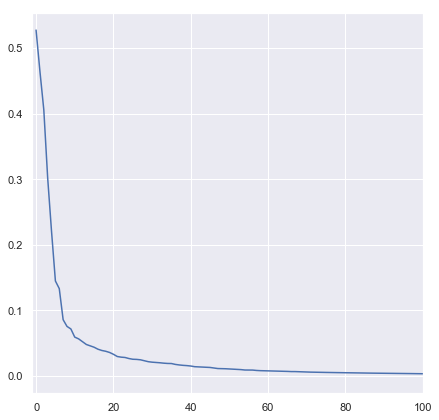

In [40]:
sns.set(rc={'figure.figsize':(7,7)})
fig, ax = plt.subplots()
ax.plot(pca.explained_variance_)
ax.set_xlim(-1, 100);

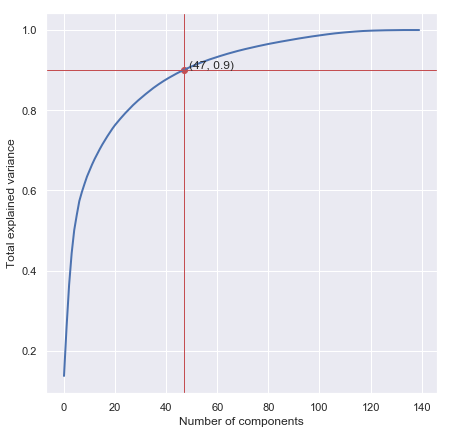

In [41]:
pca_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(pca_explained_variance_ratio, lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
optimal = (np.where(pca_explained_variance_ratio ==
                    pca_explained_variance_ratio[pca_explained_variance_ratio>0.9][0])[0][0], 0.9)
plt.axvline(optimal[0], c='r', lw=1)
plt.axhline(optimal[1], c='r', lw=1)
plt.scatter(x=optimal[0], y=optimal[1], marker='o', c='r', )
plt.annotate(s='{label}'.format(label=optimal),
                 xy=(optimal[0] + 2, optimal[1] + 0.005))
plt.show();

In [42]:
del pca_data

In [43]:
pca = PCA(n_components=45)
pca_data = pca.fit_transform(data)

In [44]:
from sklearn.manifold import TSNE
vis_data = TSNE().fit_transform(pca_data[:5000])

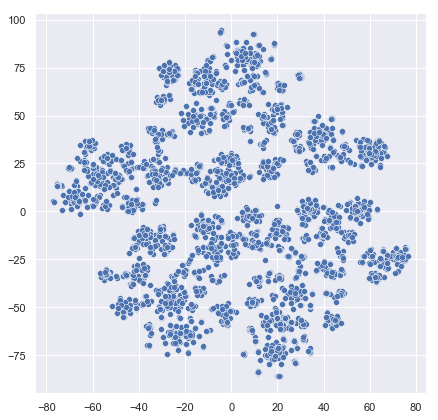

In [45]:
# plotting
fig, ax =plt.subplots()
sns.set(rc={'figure.figsize':(10,10)})
sns.scatterplot(x=vis_data[:, 0], y=vis_data[:, 1], ax=ax);


In [46]:
from sklearn.cluster import KMeans
# KMeans
# predicting
km = KMeans(n_clusters=2)
predict_km = km.fit_predict(pca_data)

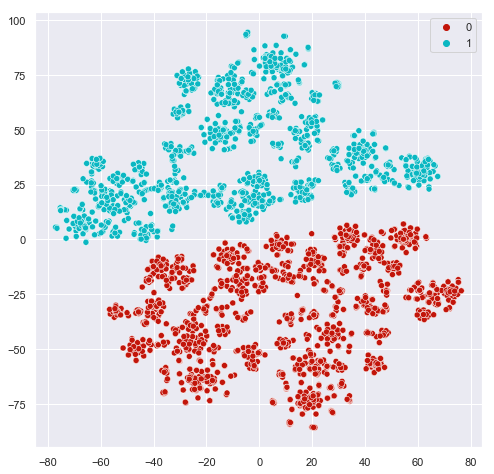

In [49]:
sns.set(rc={'figure.figsize':(8,8)})

palette = sns.hls_palette(km.n_clusters, l=.4, s=.9)
sns.scatterplot(x=vis_data[:, 0], y=vis_data[:, 1],
                hue=predict_km[:5000], palette=palette);

In [52]:
from sklearn.metrics import silhouette_score
silhouette_score(X=pca_data[:3000], labels=predict_km[:3000])

0.14780349282762595

In [52]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering, KMeans
sil_list_km = []
sil_list_agg = []
for i in range(2, 100):
    sil_list_km.append((silhouette_score(X=pca_data[:3000], labels=KMeans(n_clusters=i).fit_predict(pca_data[:3000])), i))
    sil_list_agg.append((silhouette_score(X=pca_data[:3000], labels=AgglomerativeClustering(n_clusters=i).fit_predict(pca_data[:3000])), i))

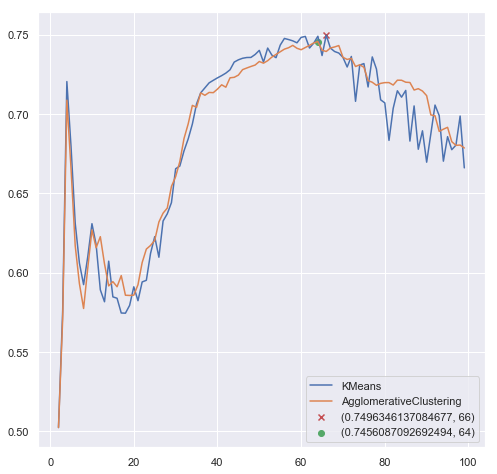

In [57]:
x1, y1 = [i[1] for i in sil_list_km], [j[0] for j in sil_list_km]
x2, y2 = [i[1] for i in sil_list_agg], [j[0] for j in sil_list_agg]
plt.plot(x1, y1, label='KMeans')
plt.plot(x2, y2, label='AgglomerativeClustering')
optimal_for_km = max(sil_list_km)
optimal_for_agg = max(sil_list_agg)
plt.scatter(x=optimal_for_km[1], y=optimal_for_km[0], marker='x', c='r', label='{}'.format(optimal_for_km))
plt.scatter(x=optimal_for_agg[1], y=optimal_for_agg[0], marker='o', c='g', label='{}'.format(optimal_for_agg))
plt.legend();

In [60]:
agg = AgglomerativeClustering(n_clusters=64)

predict_agg = agg.fit_predict(pca_data[:5000])

In [53]:
tt = df[:5000]

In [55]:
tt['pred'] = predict_km[:5000]
tt['open_account_flg'] = trarget[:5000]

In [69]:
dictionary_function={
                     'pred': lambda x: x.value_counts().idxmax(),
                    #  'open_account_flg': lambda x: x.value_counts().idxmax(),
                     'gender': lambda x: x.value_counts().idxmax(),
                     'age': np.mean,
                     'marital_status': lambda x: x.value_counts().idxmax(),
                     'job_position':lambda x: x.value_counts().idxmax(),
                     'credit_sum': np.mean,
                     'credit_month': np.median,
                     'tariff_id': lambda x: x.value_counts().idxmax(),
                     'score_shk': np.mean,
                     'education': lambda x: x.value_counts().idxmax(),
                    #  'living_region': lambda x: x.value_counts().idxmax(),
                     'monthly_income': np.mean,
                     'credit_count': lambda x: x.value_counts().idxmax(),
                     'overdue_credit_count': lambda x: x.value_counts().idxmax()}
                     
client_profile_agg = tt.groupby(['living_region', 'open_account_flg']).agg(dictionary_function)

In [70]:
client_profile_agg

1                   28892.857143           2.0   
ВОЛОГОДСКАЯ            0                   34571.621622           1.0   
                       1                   34000.000000           2.0   
ВОРОНЕЖСКАЯ            0                   33520.000000           1.0   
                       1                   21485.714286           0.0   
ДАГЕСТАН               0                   40000.000000           2.0   
ЕВРЕЙСКАЯ              0                   37333.333333           2.0   
ЗАБАЙКАЛЬСКИЙ          0                   40644.444444           2.0   
                       1                   38727.272727           2.0   
ИВАНОВСКАЯ             0                   27400.000000           0.0   
                       1                   25000.000000           0.0   
ИРКУТСКАЯ              0                   40637.486726           2.0   
                       1                   37812.939394           1.0   
КАБАРДИНО БАЛКАРСКАЯ   0                   35687.500000           1.0   
                       1                   33460.000000           1.0   
КАЛИНИНГРАДСКАЯ        0                   36125.000000           4.0   
                       1                   33500.000000           2.0   
КАЛМЫКИЯ               0                   31228.571429           2.0   
                       1                   15000.000000           2.0   
КАЛУЖСКАЯ              0                   44250.000000           2.0   
                       1                   27666.666667           0.0   
КАМЧАТСКИЙ             0                   60285.714286           1.0   
                       1                   72500.000000           1.0   
КАРАЧАЕВО ЧЕРКЕССКАЯ   0                   29860.000000           3.0   
                       1                   24333.333333           3.0   
КАРЕЛИЯ                0                   43071.428571           1.0   
                       1                   32500.000000           2.0   
КЕМЕРОВСКАЯ            0                   29847.142857           2.0   
                       1                   26436.363636           2.0   
КИРОВСКАЯ              0                   29875.000000           0.0   
                       1                   25833.333333           2.0   
КОМИ                   0                   51048.780488           2.0   
                       1                   42346.153846           1.0   
КОСТРОМСКАЯ            0                   24529.411765           1.0   
                       1                   30000.000000           1.0   
КРАСНОДАРСКИЙ          0                   38141.081081           1.0   
                       1                   32641.538462           2.0   
КРАСНОЯРСКИЙ           0                   36032.258065           2.0   
                       1                   44095.238095           1.0   
КУРГАНСКАЯ             0                   31615.384615           1.0   
                       1                   46714.285714           2.0   
КУРСКАЯ                0                   29768.292683           1.0   
                       1                   28333.333333           2.0   
ЛЕНИНГРАДСКАЯ          0                   40128.840000           1.0   
                       1                   43684.210526           1.0   
ЛИПЕЦКАЯ               0                   26975.000000           0.0   
                       1                   30000.000000           1.0   
МАГАДАНСКАЯ            0                   53250.000000           1.0   
МАРИЙ                  0                   32625.000000           2.0   
                       1                   31000.000000           2.0   
МОРДОВИЯ               0                   22230.000000           2.0   
                       1                   19250.000000           1.0   
МОСКВА                 0                   64279.538462           1.0   
                       1                   53023.333333           2.0   
МОСКОВСКАЯ             0                   52355.198697           1.0   
        

In [100]:
df

gender   age marital_status job_position  credit_sum  credit_month  \
0           M  34.0            MAR          UMN    59998.00            10   
1           F  34.0            MAR          UMN    10889.00             6   
2           M  32.0            MAR          SPC    10728.00            12   
3           F  27.0            MAR          SPC    12009.09            12   
4           M  45.0            MAR          SPC    21229.00            10   
...       ...   ...            ...          ...         ...           ...   
170741      F  27.0            UNM          SPC    64867.00            12   
170742      F  24.0            MAR          SPC    17640.00             6   
170743      F  31.0            UNM          SPC    27556.47            10   
170744      F  53.0            DIV          PNA     6189.00            12   
170745      M  49.0            MAR          SPC    12787.00            10   

       tariff_id  score_shk education    living_region  monthly_income  \
0            1.6   0.461599       GRD    КРАСНОДАРСКИЙ         30000.0   
1            1.1   0.461599       SCH           МОСКВА         35000.0   
2            1.1   0.461599       SCH      САРАТОВСКАЯ         35000.0   
3            1.1   0.461599       SCH    ВОЛГОГРАДСКАЯ         35000.0   
4            1.1   0.421385       SCH      ЧЕЛЯБИНСКАЯ         35000.0   
...          ...        ...       ...              ...             ...   
170741       1.1   0.535257       GRD        ТАТАРСТАН         40000.0   
170742       1.6   0.573287       SCH  САНКТ ПЕТЕРБУРГ         30000.0   
170743      1.32   0.416098       GRD       ПРИМОРСКИЙ         40000.0   
170744       1.1   0.482595       SCH       ПЕНЗЕНСКАЯ         31000.0   
170745       1.1   0.316087       GRD       МОСКОВСКАЯ         40000.0   

        credit_count  overdue_credit_count  
0                1.0                   1.0  
1                2.0                   0.0  
2                5.0                   0.0  
3                2.0                   0.0  
4                1.0                   0.0  
...              ...                   ...  
170741           6.0                   0.0  
170742           1.0                   0.0  
170743           1.0                   0.0  
170744           2.0                   0.0  
170745           3.0                   0.0  

[170746 rows x 13 columns]

## Выделяю рабочий набор данных

In [40]:
# normal_data_presentation_df все (170746) данные в нормльном предствлении.
normal_data_presentation_df = df.copy()

In [41]:
normal_data_presentation_df

gender   age marital_status job_position  credit_sum  credit_month  \
0           M  34.0            MAR          UMN    59998.00            10   
1           F  34.0            MAR          UMN    10889.00             6   
2           M  32.0            MAR          SPC    10728.00            12   
3           F  27.0            MAR          SPC    12009.09            12   
4           M  45.0            MAR          SPC    21229.00            10   
...       ...   ...            ...          ...         ...           ...   
170741      F  27.0            UNM          SPC    64867.00            12   
170742      F  24.0            MAR          SPC    17640.00             6   
170743      F  31.0            UNM          SPC    27556.47            10   
170744      F  53.0            DIV          PNA     6189.00            12   
170745      M  49.0            MAR          SPC    12787.00            10   

       tariff_id  score_shk education       living_region  monthly_income  \
0            1.6   0.461599       GRD       КРАСНОДАРСКИЙ         30000.0   
1            1.1   0.461599       SCH              МОСКВА         35000.0   
2            1.1   0.461599       SCH         САРАТОВСКАЯ         35000.0   
3            1.1   0.461599       SCH       ВОЛГОГРАДСКАЯ         35000.0   
4            1.1   0.421385       SCH  ЧЕЛЯБИНСКАЯОБЛАСТЬ         35000.0   
...          ...        ...       ...                 ...             ...   
170741       1.1   0.535257       GRD           ТАТАРСТАН         40000.0   
170742       1.6   0.573287       SCH      САНКТПЕТЕРБУРГ         30000.0   
170743      1.32   0.416098       GRD          ПРИМОРСКИЙ         40000.0   
170744       1.1   0.482595       SCH          ПЕНЗЕНСКАЯ         31000.0   
170745       1.1   0.316087       GRD          МОСКОВСКАЯ         40000.0   

        credit_count  overdue_credit_count open_account_flg  
0                1.0                   1.0                0  
1                2.0                   0.0                0  
2                5.0                   0.0                0  
3                2.0                   0.0                0  
4                1.0                   0.0                0  
...              ...                   ...              ...  
170741           6.0                   0.0                0  
170742           1.0                   0.0                0  
170743           1.0                   0.0                0  
170744           2.0                   0.0                0  
170745           3.0                   0.0                0  

[170746 rows x 14 columns]

In [42]:
normal_data_presentation_df_5000 = normal_data_presentation_df.sample(n=7000)
df = normal_data_presentation_df_5000.copy()

In [43]:
# normal_data_presentation_df_5000 набор данных из 7000 объектов в нормальном виде.
normal_data_presentation_df_5000

gender   age marital_status job_position  credit_sum  credit_month  \
117957      M  37.0            MAR          BIS     24816.1            12   
2110        M  30.0            MAR          SPC     87580.0            14   
131159      F  35.0            DIV          SPC     34901.0            12   
17067       M  66.0            MAR          PNA     16401.0            10   
93813       M  46.0            DIV          SPC     12569.0            10   
...       ...   ...            ...          ...         ...           ...   
73997       F  38.0            MAR          SPC     12319.0            10   
129250      M  25.0            MAR          SPC     30377.0            12   
117109      M  47.0            MAR          SPC     17119.0            10   
135933      F  52.0            MAR          SPC     12809.0            10   
84436       M  36.0            MAR          SPC     26340.0            24   

       tariff_id  score_shk education   living_region  monthly_income  \
117957       1.6   0.631613       SCH   ВОЛГОГРАДСКАЯ         45000.0   
2110           1   0.308087       GRD     ВОЛОГОДСКАЯ         40000.0   
131159       1.6   0.574241       GRD       ТАТАРСТАН         42000.0   
17067       1.32   0.459992       SCH        ПЕРМСКИЙ         22000.0   
93813        1.1   0.382275       SCH  САНКТПЕТЕРБУРГ         70000.0   
...          ...        ...       ...             ...             ...   
73997        1.1   0.288983       GRD    ОРЕНБУРГСКАЯ         25000.0   
129250       1.6   0.709336       GRD    ВЛАДИМИРСКАЯ         25000.0   
117109       1.6   0.559100       SCH    ВЛАДИМИРСКАЯ         23000.0   
135933       1.1   0.399450       SCH      ПРИМОРСКИЙ         10000.0   
84436        1.1   0.345969       GRD      МОСКОВСКАЯ         45000.0   

        credit_count  overdue_credit_count open_account_flg  
117957           0.0                   0.0                0  
2110             5.0                   0.0                0  
131159           7.0                   1.0                0  
17067            1.0                   0.0                1  
93813            2.0                   0.0                0  
...              ...                   ...              ...  
73997            1.0                   0.0                0  
129250           2.0                   0.0                1  
117109           2.0                   0.0                0  
135933           1.0                   0.0                0  
84436            4.0                   0.0                0  

[7000 rows x 14 columns]

In [44]:
# Выделенные 7000 данных которые будут преобразовываться в вид пригодный для работы. 
df

gender   age marital_status job_position  credit_sum  credit_month  \
117957      M  37.0            MAR          BIS     24816.1            12   
2110        M  30.0            MAR          SPC     87580.0            14   
131159      F  35.0            DIV          SPC     34901.0            12   
17067       M  66.0            MAR          PNA     16401.0            10   
93813       M  46.0            DIV          SPC     12569.0            10   
...       ...   ...            ...          ...         ...           ...   
73997       F  38.0            MAR          SPC     12319.0            10   
129250      M  25.0            MAR          SPC     30377.0            12   
117109      M  47.0            MAR          SPC     17119.0            10   
135933      F  52.0            MAR          SPC     12809.0            10   
84436       M  36.0            MAR          SPC     26340.0            24   

       tariff_id  score_shk education   living_region  monthly_income  \
117957       1.6   0.631613       SCH   ВОЛГОГРАДСКАЯ         45000.0   
2110           1   0.308087       GRD     ВОЛОГОДСКАЯ         40000.0   
131159       1.6   0.574241       GRD       ТАТАРСТАН         42000.0   
17067       1.32   0.459992       SCH        ПЕРМСКИЙ         22000.0   
93813        1.1   0.382275       SCH  САНКТПЕТЕРБУРГ         70000.0   
...          ...        ...       ...             ...             ...   
73997        1.1   0.288983       GRD    ОРЕНБУРГСКАЯ         25000.0   
129250       1.6   0.709336       GRD    ВЛАДИМИРСКАЯ         25000.0   
117109       1.6   0.559100       SCH    ВЛАДИМИРСКАЯ         23000.0   
135933       1.1   0.399450       SCH      ПРИМОРСКИЙ         10000.0   
84436        1.1   0.345969       GRD      МОСКОВСКАЯ         45000.0   

        credit_count  overdue_credit_count open_account_flg  
117957           0.0                   0.0                0  
2110             5.0                   0.0                0  
131159           7.0                   1.0                0  
17067            1.0                   0.0                1  
93813            2.0                   0.0                0  
...              ...                   ...              ...  
73997            1.0                   0.0                0  
129250           2.0                   0.0                1  
117109           2.0                   0.0                0  
135933           1.0                   0.0                0  
84436            4.0                   0.0                0  

[7000 rows x 14 columns]

In [45]:
target = df.open_account_flg
df.drop(columns='open_account_flg', inplace=True)
df.head()

gender   age marital_status job_position  credit_sum  credit_month  \
117957      M  37.0            MAR          BIS     24816.1            12   
2110        M  30.0            MAR          SPC     87580.0            14   
131159      F  35.0            DIV          SPC     34901.0            12   
17067       M  66.0            MAR          PNA     16401.0            10   
93813       M  46.0            DIV          SPC     12569.0            10   

       tariff_id  score_shk education   living_region  monthly_income  \
117957       1.6   0.631613       SCH   ВОЛГОГРАДСКАЯ         45000.0   
2110           1   0.308087       GRD     ВОЛОГОДСКАЯ         40000.0   
131159       1.6   0.574241       GRD       ТАТАРСТАН         42000.0   
17067       1.32   0.459992       SCH        ПЕРМСКИЙ         22000.0   
93813        1.1   0.382275       SCH  САНКТПЕТЕРБУРГ         70000.0   

        credit_count  overdue_credit_count  
117957           0.0                   0.0  
2110             5.0                   0.0  
131159           7.0                   1.0  
17067            1.0                   0.0  
93813            2.0                   0.0

## Работа с категориальными данными

### One-Hot Encoding

In [46]:
# имена всех категориальные переменные в одном списке 
name_colums_with_type_object = [i for i in df.columns if df[i].dtype.name == 'object']
# имена не категориальных переменных
name_columns_not_object = [i for i in df.columns if df[i].dtype.name != 'object']



## Этап эксперимента

Выделим данные для выявления оптимального подхода для работы

data - данные для работы во всех ветках (те не нормализованые и без polynomial)

df_a - данные для MinMaxScaler
<br>df_b - данные для StandartScaler

In [48]:
data = pd.get_dummies(data=df)

df_a = data.copy() # MinMaxScaler
df_b = data.copy() # StandartScaler

## Нормализация по `MinMaxScaler`

В `df_a` находятся данные которые будут нормализованы по MinMaxScaler.
<br>MinMaxScaler можно применять ко всем типам данных (те можно применить к категориальным данным преобразованым в бинарный вид)



In [49]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df_a = pd.DataFrame(scaler.fit_transform(df_a), columns=df_a.columns, index=df_a.index)
df_a.head()

age  credit_sum  credit_month  score_shk  monthly_income  \
18467   0.509434    0.112832      0.212121   0.455364        0.007527   
46592   0.396226    0.050442      0.272727   0.673225        0.051075   
75461   0.301887    0.053594      0.212121   0.364976        0.028226   
5573    0.698113    0.096284      0.272727   0.431539        0.059140   
104747  0.415094    0.287152      0.212121   0.502614        0.032258   

        credit_count  overdue_credit_count  gender_F  gender_M  \
18467       0.076923                   0.0       1.0       0.0   
46592       0.153846                   0.0       1.0       0.0   
75461       0.153846                   0.0       0.0       1.0   
5573        0.000000                   0.0       1.0       0.0   
104747      0.153846                   0.0       1.0       0.0   

        marital_status_CIV  ...  living_region_ХАКАСИЯ  \
18467                  0.0  ...                    0.0   
46592                  0.0  ...                    0.0   
75461                  0.0  ...                    0.0   
5573                   0.0  ...                    0.0   
104747                 0.0  ...                    0.0   

        living_region_ХАНТЫ-МАНСИЙСКИЙ  living_region_ХАНТЫМАНСИЙСКИЙ  \
18467                              0.0                            0.0   
46592                              0.0                            0.0   
75461                              0.0                            0.0   
5573                               0.0                            0.0   
104747                             0.0                            0.0   

        living_region_ЧЕЛЯБИНСКАЯ  living_region_ЧЕЛЯБИНСКАЯОБЛАСТЬ  \
18467                         0.0                               0.0   
46592                         0.0                               0.0   
75461                         0.0                               0.0   
5573                          0.0                               0.0   
104747                        0.0                               0.0   

        living_region_ЧЕЧЕНСКАЯ  living_region_ЧУВАШСКАЯ  \
18467                       0.0                      0.0   
46592                       0.0                      0.0   
75461                       0.0                      0.0   
5573                        0.0                      0.0   
104747                      0.0                      0.0   

        living_region_ЯМАЛОНЕНЕЦКИЙ  living_region_ЯРОСЛАВСКАЯ  \
18467                           0.0                        0.0   
46592                           0.0                        0.0   
75461                           0.0                        0.0   
5573                            0.0                        0.0   
104747                          0.0                        0.0   

        living_region_ЯРОСЛАВСКАЯОБЛАСТЬ  
18467                                0.0  
46592                                0.0  
75461                                0.0  
5573                                 0.0  
104747                               0.0  

[5 rows x 169 columns]

## Нормализация по `StandartScaler`

В `df_b` находятся данные которые будут нормализованы по MinMaxScaler.
<br>Стоит отметить, что StandartScaler применяется к данным не категориального типа.
<br>`name_columns_not_object` - список имен признаков не категориального типа

In [50]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# не бинарные данные к которым применяется нормализация StandartScaler
# name_columns_not_object - имена колонок с не бинарными данными
scalerdf_b = pd.DataFrame(data=scaler.fit_transform(df_b[name_columns_not_object]), columns=name_columns_not_object, index=df_b.index)

# 
for i in scalerdf_b.columns:
    df_b[i] = scalerdf_b[i].values
del scalerdf_b

df_b.head()

age  credit_sum  credit_month  score_shk  monthly_income  \
18467   0.799475   -0.055664     -0.284315  -0.036236       -1.059787   
46592   0.231618   -0.793948      0.280443   1.467653        0.120307   
75461  -0.241596   -0.756646     -0.284315  -0.660184       -0.498878   
5573    1.745903   -0.251482      0.280443  -0.200702        0.338843   
104747  0.326261    2.007099     -0.284315   0.289931       -0.389610   

        credit_count  overdue_credit_count  gender_F  gender_M  \
18467      -0.651645             -0.214539         1         0   
46592      -0.072993             -0.214539         1         0   
75461      -0.072993             -0.214539         0         1   
5573       -1.230297             -0.214539         1         0   
104747     -0.072993             -0.214539         1         0   

        marital_status_CIV  ...  living_region_ХАКАСИЯ  \
18467                    0  ...                      0   
46592                    0  ...                      0   
75461                    0  ...                      0   
5573                     0  ...                      0   
104747                   0  ...                      0   

        living_region_ХАНТЫ-МАНСИЙСКИЙ  living_region_ХАНТЫМАНСИЙСКИЙ  \
18467                                0                              0   
46592                                0                              0   
75461                                0                              0   
5573                                 0                              0   
104747                               0                              0   

        living_region_ЧЕЛЯБИНСКАЯ  living_region_ЧЕЛЯБИНСКАЯОБЛАСТЬ  \
18467                           0                                 0   
46592                           0                                 0   
75461                           0                                 0   
5573                            0                                 0   
104747                          0                                 0   

        living_region_ЧЕЧЕНСКАЯ  living_region_ЧУВАШСКАЯ  \
18467                         0                        0   
46592                         0                        0   
75461                         0                        0   
5573                          0                        0   
104747                        0                        0   

        living_region_ЯМАЛОНЕНЕЦКИЙ  living_region_ЯРОСЛАВСКАЯ  \
18467                             0                          0   
46592                             0                          0   
75461                             0                          0   
5573                              0                          0   
104747                            0                          0   

        living_region_ЯРОСЛАВСКАЯОБЛАСТЬ  
18467                                  0  
46592                                  0  
75461                                  0  
5573                                   0  
104747                                 0  

[5 rows x 169 columns]

Из df_a: 
    <br>df_a1 -- > + PF, + PCA.
    <br>df_a2 -- > + PCA, - PF.
    <br>df_a3 -- > + PF, - PCA.
    <br>df_a4 -- > - PF, -PCA.

Из df_b: 
    <br>df_b1 -- > + PF, + PCA.
    <br>df_b2 -- > + PCA, - PF.
    <br>df_b3 -- > + PF, - PCA.
    <br>df_b4 -- > - PF, -PCA.


**Гипотиза**: влияет ли на качество приминение PolynomialFeatures к отдельным признакам

In [51]:
df_a1 = df_a.copy()
df_a2 = df_a.copy()
df_a3 = df_a.copy()
df_a4 = df_a.copy()


df_b1 = df_b.copy()
df_b2 = df_b.copy()
df_b3 = df_b.copy()
df_b4 = df_b.copy() 

## Применяю `PolynomialFeatures` к данным

<br>`name_columns_not_object` - имена не категориальных признаков

In [52]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)

# приминяю PolynomialFeatures к данным не бинарного типа из данных df_a
data_poly = pd.DataFrame(data=poly.fit_transform(df_a[name_columns_not_object]), 
                        columns=poly.get_feature_names())


# приминяю PolynomialFeatures к данным не бинарного типа из данных df_b
data_poly = pd.DataFrame(data=poly.fit_transform(df_b[name_columns_not_object]), 
                        columns=poly.get_feature_names())

# удаляю колонки, к которым применялся PolynomialFeatures, тк в объектах data_poly_a1 и data_poly_b1 эти колонки будут пристутсвоать как x0
df_a1.drop(columns=name_columns_not_object, inplace=True)
df_a3.drop(columns=name_columns_not_object, inplace=True)

df_b1.drop(columns=name_columns_not_object, inplace=True)
df_b3.drop(columns=name_columns_not_object, inplace=True)

In [55]:
# добовляю в исходные датафреймы данные после PolynomialFeatures 
for i in data_poly.columns:
    df_a1[i] = data_poly[i].values
    df_b1[i] = data_poly[i].values
    df_a3[i] = data_poly[i].values
    df_b3[i] = data_poly[i].values

In [56]:
df_a1.head()

gender_F  gender_M  marital_status_CIV  marital_status_DIV  \
18467        1.0       0.0                 0.0                 1.0   
46592        1.0       0.0                 0.0                 0.0   
75461        0.0       1.0                 0.0                 0.0   
5573         1.0       0.0                 0.0                 1.0   
104747       1.0       0.0                 0.0                 0.0   

        marital_status_MAR  marital_status_UNM  marital_status_WID  \
18467                  0.0                 0.0                 0.0   
46592                  0.0                 1.0                 0.0   
75461                  1.0                 0.0                 0.0   
5573                   0.0                 0.0                 0.0   
104747                 1.0                 0.0                 0.0   

        job_position_ATP  job_position_BIS  job_position_BIU  ...      x3^2  \
18467                0.0               0.0               0.0  ...  0.001313   
46592                0.0               0.0               0.0  ...  2.154006   
75461                0.0               0.0               0.0  ...  0.435842   
5573                 0.0               0.0               0.0  ...  0.040281   
104747               0.0               0.0               0.0  ...  0.084060   

           x3 x4     x3 x5     x3 x6      x4^2     x4 x5     x4 x6      x5^2  \
18467   0.038403  0.023613  0.007774  1.123148  0.690605  0.227366  0.424641   
46592   0.176569 -0.107128 -0.314869  0.014474 -0.008782 -0.025811  0.005328   
75461   0.329351  0.048189  0.141635  0.248879  0.036415  0.107029  0.005328   
5573   -0.068007  0.246923  0.043059  0.114814 -0.416877 -0.072695  1.513631   
104747 -0.112960 -0.021163 -0.062202  0.151796  0.028439  0.083587  0.005328   

           x5 x6      x6^2  
18467   0.139803  0.046027  
46592   0.015660  0.046027  
75461   0.015660  0.046027  
5573    0.263947  0.046027  
104747  0.015660  0.046027  

[5 rows x 198 columns]

# PCA
## Каменная осыпь

Посик области значений оптимального числа компанент для `PCA`

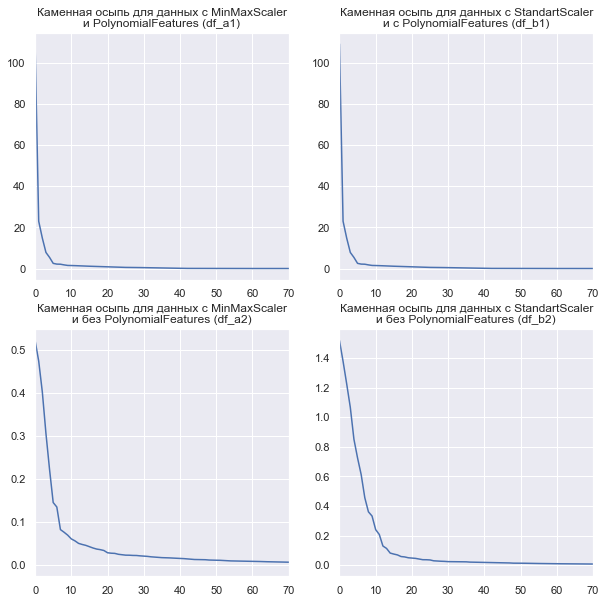

In [57]:
from sklearn.decomposition import PCA

pca_a1 = PCA()
pca_a2 = PCA()
pca_b1 = PCA()
pca_b2 = PCA()

# pca к данным c PolynomialFeatures

# df_a1
pca_a1.fit(df_a1)
df_a1_pca = pca_a1.fit_transform(df_a1)

# df_b1
pca_b1.fit(df_b1)
df_b1_pca = pca_b1.transform(df_b1)

# pca к данным без PolynomialFeatures

# df_a2
pca_a2.fit(df_a2)
df_a2_pca = pca_a2.transform(df_a2)

# df_b2
pca_b2.fit(df_b2)
df_b2_pca = pca_b2.transform(df_b2)

# Построение каменной осыпи
sns.set(rc={'figure.figsize':(10,10)})
fig, ax = plt.subplots(ncols=2, nrows=2)

ax[0, 0].plot(pca_a1.explained_variance_)
ax[0, 0].set_title(label='Каменная осыпь для данных с MinMaxScaler\nи PolynomialFeatures (df_a1)')
ax[0, 0].set_xlim(0, 70);

ax[1, 0].plot(pca_a2.explained_variance_)
ax[1, 0].set_title(label='Каменная осыпь для данных с MinMaxScaler\nи без PolynomialFeatures (df_a2)')
ax[1, 0].set_xlim(0, 70);

ax[0, 1].plot(pca_b1.explained_variance_)
ax[0, 1].set_title(label='Каменная осыпь для данных с StandartScaler\nи с PolynomialFeatures (df_b1)')
ax[0, 1].set_xlim(0, 70);

ax[1, 1].plot(pca_b2.explained_variance_)
ax[1, 1].set_title(label='Каменная осыпь для данных с StandartScaler\nи без PolynomialFeatures (df_b2)')
ax[1, 1].set_xlim(0, 70);

Число компанент для набора данных `df_a1` (MinMaxScaler и PolynomialFeatures) находится в пределе от 7 до (приблизительно) 10
<br>Число компанент для набора данных `df_a2` (MinMaxScaler и **БЕЗ** PolynomialFeatures) находится в пределе от 7 до (приблизительно) 40-50
<br>Число компанент для набора данных `df_b1` (StandartScaler и PolynomialFeatures) находится в пределе от 3-4 до (приблизительно) 10-15
<br>Число компанент для набора данных `df_b2` (StandartScaler и **БЕЗ** PolynomialFeatures) находится в пределе от 10-15 до (приблизительно) 30-40

In [79]:
# pca_explained_variance_ratio = np.cumsum(pca_a2.explained_variance_ratio_)
# plt.plot(pca_explained_variance_ratio, lw=2)
# plt.xlabel('Number of components')
# plt.ylabel('Total explained variance')
# optimal = (np.where(pca_explained_variance_ratio ==
#                     pca_explained_variance_ratio[pca_explained_variance_ratio>0.9][0])[0][0], 0.9)
# plt.axvline(optimal[0], c='r', lw=1)
# plt.axhline(optimal[1], c='r', lw=1)
# plt.scatter(x=optimal[0], y=optimal[1], marker='o', c='r', )
# plt.annotate(s='{label}'.format(label=optimal),
#                  xy=(optimal[0] + 2, optimal[1] + 0.005))
# plt.show();

На данном этапе возникает вопрос выбора метода предподготовки данных: Приминения PF не ко всем данным, а только к группе признаков.

Так же на этом этапе расмотрю:
    
    1. Алгоритмы классификации
    2. Метрики оценки качества классификации
    3. Будет выборано оптимальное число компанент для PCA в зависимоти от показаний метрик.

In [58]:
from sklearn.cluster import KMeans, AgglomerativeClustering

# для оценки качества кластриезации будет использоваться метрика silhouette_score
# она позволяет оценить качество кластеризации по расстоянию объектов кластера
# что похволяет оценить неразмеченные данные
from sklearn.metrics import silhouette_score

# Результаты метрик к данным с MinMaxScaler (df_a)

# результаты метрики для df_a1
metric_result_list_km_a1 = []
metric_result_list_agg_a1 = []

# результаты метрики для df_a2
metric_result_list_km_a2 = []
metric_result_list_agg_a2 = []

# Результаты метрик к данным с StandartScaler (df_b)

# результаты метрики для df_b1
metric_result_list_km_b1 = []
metric_result_list_agg_b1 = []

# результаты метрики для df_b2
metric_result_list_km_b2 = []
metric_result_list_agg_b2 = []

for i_companion in range(10, 30, 10):
    # для df_a1
    pca_a = PCA(n_components=i_companion)
    pca_a.fit(df_a1)
    df_pca_a1 = pca_a1.transform(df_a1)
    
    # для df_a2
    pca_a2 = PCA(n_components=i_companion)
    pca_a2.fit(df_a2)
    df_pca_a2 = pca_a2.transform(df_a2)

    # для df_b1
    pca_b1 = PCA(n_components=i_companion)
    pca_b1.fit(df_b1)
    df_pca_b1 = pca_b1.transform(df_b1)

    # для df_b2
    pca_b2 = PCA(n_components=i_companion)
    pca_b2.fit(df_b2)
    df_pca_b2 = pca_b2.transform(df_b2)

    silhouette_score_km_a1 = []
    silhouette_score_agg_a1 = []

    silhouette_score_km_a2 = []
    silhouette_score_agg_a2 = []

    silhouette_score_km_b1 = []
    silhouette_score_agg_b1 = []
    
    silhouette_score_km_b2 = []
    silhouette_score_agg_b2 = []

    for i in range(2, 70):
        # a
        silhouette_score_km_a1.append((silhouette_score(X=df_pca_a1,
                                                      labels=KMeans(n_clusters=i).fit_predict(df_pca_a1)), i))
        silhouette_score_agg_a1.append((silhouette_score(X=df_pca_a1,
                                                      labels=AgglomerativeClustering(n_clusters=i).fit_predict(df_pca_a1)), i))

        silhouette_score_km_a2.append((silhouette_score(X=df_pca_a2,
                                                      labels=KMeans(n_clusters=i).fit_predict(df_pca_a2)), i))
        silhouette_score_agg_a2.append((silhouette_score(X=df_pca_a2,
                                                      labels=AgglomerativeClustering(n_clusters=i).fit_predict(df_pca_a2)), i))
        
        # b
        silhouette_score_km_b1.append((silhouette_score(X=df_pca_b1,
                                                      labels=KMeans(n_clusters=i).fit_predict(df_pca_b1)), i))  
        silhouette_score_agg_b1.append((silhouette_score(X=df_pca_b1,
                                                      labels=AgglomerativeClustering(n_clusters=i).fit_predict(df_pca_b1)), i))

        silhouette_score_km_b2.append((silhouette_score(X=df_pca_b2,
                                                      labels=KMeans(n_clusters=i).fit_predict(df_pca_b2)), i))  
        silhouette_score_agg_b2.append((silhouette_score(X=df_pca_b2,
                                                      labels=AgglomerativeClustering(n_clusters=i).fit_predict(df_pca_b2)), i))


    metric_result_list_km_a1.append((i_companion, max(silhouette_score_km_a1)))
    metric_result_list_agg_a1.append((i_companion, max(silhouette_score_agg_a1)))

    metric_result_list_km_a2.append((i_companion, max(silhouette_score_km_a2)))
    metric_result_list_agg_a2.append((i_companion, max(silhouette_score_agg_a2)))

    metric_result_list_km_b1.append((i_companion, max(silhouette_score_km_b1)))
    metric_result_list_agg_b1.append((i_companion, max(silhouette_score_agg_b1)))

    metric_result_list_km_b2.append((i_companion, max(silhouette_score_km_b2)))
    metric_result_list_agg_b2.append((i_companion, max(silhouette_score_agg_b2)))

In [60]:
metric_result_list_agg_a2

[(10, (0.6171665597011883, 69)), (20, (0.30413189940110513, 69))]

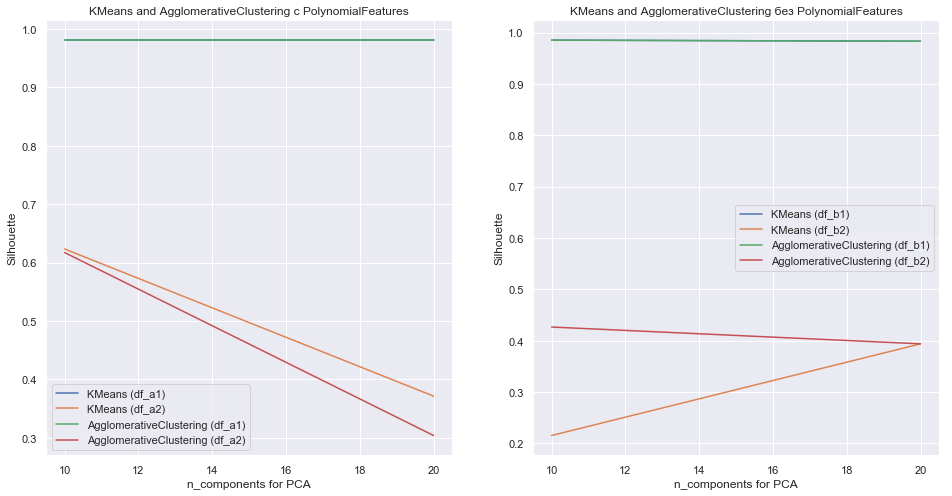

In [59]:
sns.set(rc={'figure.figsize':(16,8)})
fig, ax = plt.subplots(nrows=1, ncols=2)

# a 
# KMeans
plot_km_y_a1, plot_km_x_a1 = [i[1][0] for i in metric_result_list_km_a1], [i[0] for i in metric_result_list_km_a1]
ax[0].plot(plot_km_x_a1, plot_km_y_a1, label='KMeans (df_a1)')

plot_km_y_a2, plot_km_x_a2 = [i[1][0] for i in metric_result_list_km_a2], [i[0] for i in metric_result_list_km_a2]
ax[0].plot(plot_km_x_a2, plot_km_y_a2, label='KMeans (df_a2)')

# AgglomerativeClustering
plot_agg_y_a1, plot_agg_x_a1 = [i[1][0] for i in metric_result_list_agg_a1], [i[0] for i in metric_result_list_agg_a1]
ax[0].plot(plot_agg_x_a1, plot_agg_y_a1, label='AgglomerativeClustering (df_a1)')

plot_agg_y_a2, plot_agg_x_a2 = [i[1][0] for i in metric_result_list_agg_a2], [i[0] for i in metric_result_list_agg_a2]
ax[0].plot(plot_agg_x_a2, plot_agg_y_a2, label='AgglomerativeClustering (df_a2)')

ax[0].set_xlabel("n_components for PCA")
ax[0].set_ylabel("Silhouette")
ax[0].set_title(label='KMeans and AgglomerativeClustering c PolynomialFeatures')
ax[0].legend(['KMeans (df_a1)', 'KMeans (df_a2)', 'AgglomerativeClustering (df_a1)', 'AgglomerativeClustering (df_a2)']);

# b
# KMeans
plot_km_y_b1, plot_km_x_b1 = [i[1][0] for i in metric_result_list_km_b1], [i[0] for i in metric_result_list_km_b1]
ax[1].plot(plot_km_x_b1, plot_km_y_b1, label='KMeans (df_b1)')

plot_km_y_b2, plot_km_x_b2 = [i[1][0] for i in metric_result_list_km_b2], [i[0] for i in metric_result_list_km_b2]
ax[1].plot(plot_km_x_b2, plot_km_y_b2, label='KMeans (df_b2)')

# AgglomerativeClustering
plot_agg_y_b1, plot_agg_x_b1 = [i[1][0] for i in metric_result_list_agg_b1], [i[0] for i in metric_result_list_agg_b1]
ax[1].plot(plot_agg_x_b1, plot_agg_y_b1, label='AgglomerativeClustering (df_b1)')

plot_agg_y_b2, plot_agg_x_b2 = [i[1][0] for i in metric_result_list_agg_b2], [i[0] for i in metric_result_list_agg_b2]
ax[1].plot(plot_agg_x_b2, plot_agg_y_b2, label='AgglomerativeClustering (df_b2)')

ax[1].set_xlabel("n_components for PCA")
ax[1].set_ylabel("Silhouette")
ax[1].set_title(label='KMeans and AgglomerativeClustering без PolynomialFeatures')
ax[1].legend(['KMeans (df_b1)', 'KMeans (df_b2)', 'AgglomerativeClustering (df_b1)', 'AgglomerativeClustering (df_b2)']);

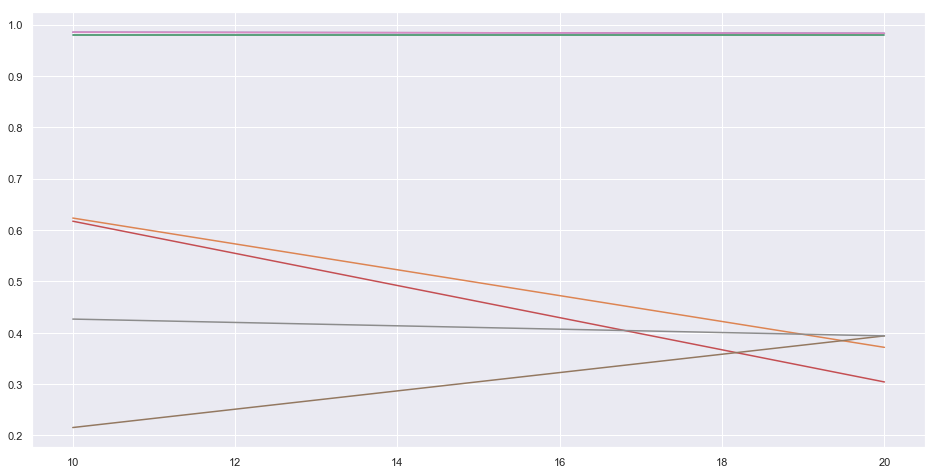

In [61]:
# Общий график

plt.plot(plot_km_x_a1, plot_km_y_a1, label='KMeans (df_a1)')
plt.plot(plot_km_x_a2, plot_km_y_a2, label='KMeans (df_a2)')
plt.plot(plot_agg_x_a1, plot_agg_y_a1, label='AgglomerativeClustering (df_a1)')
plt.plot(plot_agg_x_a2, plot_agg_y_a2, label='AgglomerativeClustering (df_a2)')
plt.plot(plot_km_x_b1, plot_km_y_b1, label='KMeans (df_b1)')
plt.plot(plot_km_x_b2, plot_km_y_b2, label='KMeans (df_b2)')
plt.plot(plot_agg_x_b1, plot_agg_y_b1, label='AgglomerativeClustering (df_b1)')
plt.plot(plot_agg_x_b2, plot_agg_y_b2, label='AgglomerativeClustering (df_b2)')


In [62]:
# функция для поиска оптимального числа компанент по результатам 
def search_max(arg):
    maximum = max([i[1] for i in arg])
    return [i[0] for i in arg if i[1] == maximum][0], maximum[1], maximum[0]

In [64]:
# оптималное число компанент в PCA для A

# KMeans 
# df_a1   
optimal_number_components_km_a1, optimal_number_clusters_km_a1, optimal_silhouette_score_km_a1 = search_max(metric_result_list_km_a1)
print('df_a1:\tОптимальное число компанент для KMeans {f1} соответсвующее оптимальному'\
      'числу кластеров {f2},\nс показателем silhouette_score = {f3:.5f}'.format(f1=optimal_number_components_km_a1,
                                                                          f2=optimal_number_clusters_km_a1,
                                                                          f3=optimal_silhouette_score_km_a1))
# df_a2
optimal_number_components_km_a2, optimal_number_clusters_km_a2, optimal_silhouette_score_km_a2 = search_max(metric_result_list_km_a2)
print('df_a2:\tОптимальное число компанент для KMeans {f1} соответсвующее оптимальному'\
      'числу кластеров {f2},\nс показателем silhouette_score = {f3:.5f}'.format(f1=optimal_number_components_km_a2,
                                                                          f2=optimal_number_clusters_km_a2,
                                                                          f3=optimal_silhouette_score_km_a2))

# AgglomerativeClustering
# df_a1
optimal_number_components_agg_a1, optimal_number_clusters_agg_a1, optimal_silhouette_score_agg_a1 = search_max(metric_result_list_agg_a1)
print('df_a1:\tОптимальное число компанент для AgglomerativeClustering {f1} соответсвующее оптимальному'\
      'числу кластеров {f2},\nс показателем silhouette_score = {f3:.5f}'.format(f1=optimal_number_components_agg_a1,
                                                                          f2=optimal_number_clusters_agg_a1,
                                                                          f3=optimal_silhouette_score_agg_a1))

optimal_number_components_agg_a2, optimal_number_clusters_agg_a2, optimal_silhouette_score_agg_a2 = search_max(metric_result_list_agg_a2)
print('df_a2:\tОптимальное число компанент для AgglomerativeClustering {f1} соответсвующее оптимальному'\
      'числу кластеров {f2},\nс показателем silhouette_score = {f3:.5f}'.format(f1=optimal_number_components_agg_a2,
                                                                          f2=optimal_number_clusters_agg_a2,
                                                                          f3=optimal_silhouette_score_agg_a2))

# оптималное число компанент в PCA для B

# KMeans    
optimal_number_components_km_b1, optimal_number_clusters_km_b1, optimal_silhouette_score_km_b1 = search_max(metric_result_list_km_b1)
print('df_b1:\tОптимальное число компанент для KMeans {f1} соответсвующее оптимальному'\
      'числу кластеров {f2},\nс показателем silhouette_score = {f3:.5f}'.format(f1=optimal_number_components_km_b1,
                                                                          f2=optimal_number_clusters_km_b1,
                                                                          f3=optimal_silhouette_score_km_b1))

optimal_number_components_km_b2, optimal_number_clusters_km_b2, optimal_silhouette_score_km_b2 = search_max(metric_result_list_km_b2)
print('df_b2:\tОптимальное число компанент для KMeans {f1} соответсвующее оптимальному'\
      'числу кластеров {f2},\nс показателем silhouette_score = {f3:.5f}'.format(f1=optimal_number_components_km_b2,
                                                                          f2=optimal_number_clusters_km_b2,
                                                                          f3=optimal_silhouette_score_km_b2))

# AgglomerativeClustering
optimal_number_components_agg_b1, optimal_number_clusters_agg_b1, optimal_silhouette_score_agg_b1 = search_max(metric_result_list_agg_b1)
print('df_b1:\tОптимальное число компанент для AgglomerativeClustering {f1} соответсвующее оптимальному'\
      'числу кластеров {f2},\nс показателем silhouette_score = {f3:.5f}'.format(f1=optimal_number_components_agg_b1,
                                                                          f2=optimal_number_clusters_agg_b1,
                                                                          f3=optimal_silhouette_score_agg_b1))

optimal_number_components_agg_b2, optimal_number_clusters_agg_b2, optimal_silhouette_score_agg_b2 = search_max(metric_result_list_agg_b2)
print('df_b2:\tОптимальное число компанент для AgglomerativeClustering {f1} соответсвующее оптимальному'\
      'числу кластеров {f2},\nс показателем silhouette_score = {f3:.5f}'.format(f1=optimal_number_components_agg_b2,
                                                                          f2=optimal_number_clusters_agg_b2,
                                                                          f3=optimal_silhouette_score_agg_b2))

df_a1:	Оптимальное число компанент для KMeans 10 соответсвующее оптимальномучислу кластеров 2,
с показателем silhouette_score = 0.98073
df_a2:	Оптимальное число компанент для KMeans 10 соответсвующее оптимальномучислу кластеров 69,
с показателем silhouette_score = 0.62332
df_a1:	Оптимальное число компанент для AgglomerativeClustering 10 соответсвующее оптимальномучислу кластеров 2,
с показателем silhouette_score = 0.98073
df_a2:	Оптимальное число компанент для AgglomerativeClustering 10 соответсвующее оптимальномучислу кластеров 69,
с показателем silhouette_score = 0.61717
df_b1:	Оптимальное число компанент для KMeans 10 соответсвующее оптимальномучислу кластеров 2,
с показателем silhouette_score = 0.98527
df_b2:	Оптимальное число компанент для KMeans 20 соответсвующее оптимальномучислу кластеров 2,
с показателем silhouette_score = 0.39382
df_b1:	Оптимальное число компанент для AgglomerativeClustering 10 соответсвующее оптимальномучислу кластеров 2,
с показателем silhouette_score = 0.9

silhouette_score = 0.98073 -- df_a1 на Kmeans, n_clusters = 2, n_components = 10
<br>silhouette_score = 0.98073 -- df_a1 на AgglomerativeClustering, n_clusters = 2, n_components = 10
<br>silhouette_score = 0.98527 -- df_b1 на Kmeans, n_clusters = 2, n_components = 10
<br>silhouette_score = 0.98527 -- df_b1 на AgglomerativeClustering, n_clusters = 2, n_components = 10

Из df_a:
    <br>df_a1 -- > + PF, + PCA.
    <br>df_a2 -- > + PCA, - PF.
    <br>df_a3 -- > + PF, - PCA.
    <br>df_a4 -- > - PF, -PCA.

Из df_b:
    <br>df_b1 -- > + PF, + PCA.
    <br>df_b2 -- > + PCA, - PF.
    <br>df_b3 -- > + PF, - PCA.
    <br>df_b4 -- > - PF, -PCA.

In [67]:
# Проверю df_a3, df_a4, df_b3, df_b4

# df_a3
silhouette_score_km_a3 = []
silhouette_score_agg_a3 = []

# df_a4
silhouette_score_km_a4 = []
silhouette_score_agg_a4 = []

# df_b3
silhouette_score_km_b3 = []
silhouette_score_agg_b3 = []

# df_b4
silhouette_score_km_b4 = []
silhouette_score_agg_b4 = []

for i in range(2, 70):
     # df_a3, KMeans
    silhouette_score_km_a3.append((silhouette_score(X=df_a3,
                                                      labels=KMeans(n_clusters=i).fit_predict(df_a3)), i))
    # df_a3, AgglomerativeClustering
    silhouette_score_agg_a3.append((silhouette_score(X=df_a3,
                                                      labels=AgglomerativeClustering(n_clusters=i).fit_predict(df_a3)), i))
    # df_a4, KMeans
    silhouette_score_km_a4.append((silhouette_score(X=df_a4,
                                                      labels=KMeans(n_clusters=i).fit_predict(df_a4)), i))
    # df_a4, AgglomerativeClustering
    silhouette_score_agg_a4.append((silhouette_score(X=df_a4,
                                                      labels=AgglomerativeClustering(n_clusters=i).fit_predict(df_a4)), i))
        
    # df_b3, KMeans
    silhouette_score_km_b3.append((silhouette_score(X=df_b3,
                                                      labels=KMeans(n_clusters=i).fit_predict(df_b3)), i))  
    # df_b3, AgglomerativeClustering
    silhouette_score_agg_b3.append((silhouette_score(X=df_b3,
                                                      labels=AgglomerativeClustering(n_clusters=i).fit_predict(df_b3)), i))

    # df_b4, KMeans
    silhouette_score_km_b4.append((silhouette_score(X=df_b4,
                                                      labels=KMeans(n_clusters=i).fit_predict(df_b4)), i))  
    # df_b4, AgglomerativeClustering
    silhouette_score_agg_b4.append((silhouette_score(X=df_b4,
                                                      labels=AgglomerativeClustering(n_clusters=i).fit_predict(df_b4)), i))

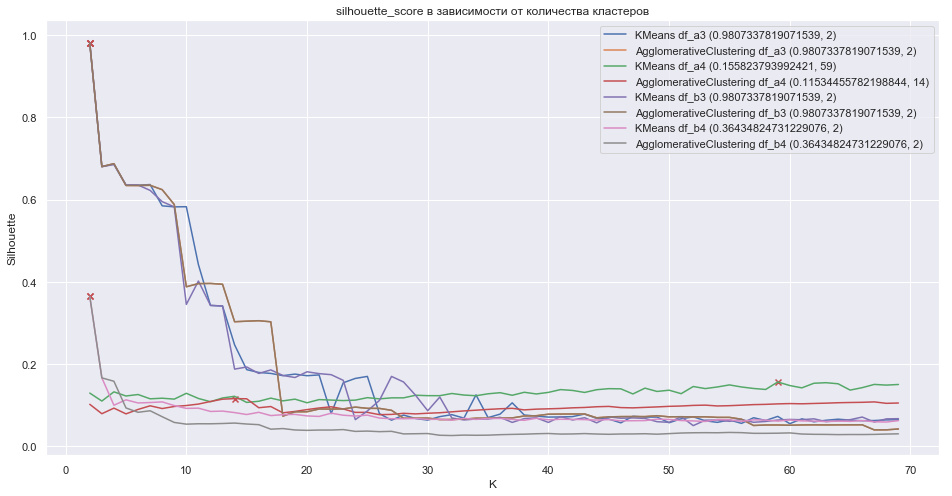

In [73]:
# df_a3
optimal_number_clusters_km_a3 = max(silhouette_score_km_a3)
optimal_number_clusters_agg_a3 = max(silhouette_score_agg_a3)

# df_a4
optimal_number_clusters_km_a4 = max(silhouette_score_km_a4)
optimal_number_clusters_agg_a4 = max(silhouette_score_agg_a4)

# df_b3
optimal_number_clusters_km_b3 = max(silhouette_score_km_b3)
optimal_number_clusters_agg_b3 = max(silhouette_score_agg_b3)

# df_b4
optimal_number_clusters_km_b4 = max(silhouette_score_km_b4)
optimal_number_clusters_agg_b4 = max(silhouette_score_agg_b4)

# построение графика изминения silhouette_score от числа кластров в алгоритме KMeans
sns.set(rc={'figure.figsize':(16,8)})

# df_a3
plot_km_y_a3, plot_km_x_a3 = [i[0] for i in silhouette_score_km_a3], [i[1] for i in silhouette_score_km_a3]
plot_agg_y_a3, plot_agg_x_a3 = [i[0] for i in silhouette_score_agg_a3], [i[1] for i in silhouette_score_agg_a3]

# df_a4
plot_km_y_a4, plot_km_x_a4 = [i[0] for i in silhouette_score_km_a4], [i[1] for i in silhouette_score_km_a4]
plot_agg_y_a4, plot_agg_x_a4 = [i[0] for i in silhouette_score_agg_a4], [i[1] for i in silhouette_score_agg_a4]

# df_b3
plot_km_y_b3, plot_km_x_b3 = [i[0] for i in silhouette_score_km_b3], [i[1] for i in silhouette_score_km_b3]
plot_agg_y_b3, plot_agg_x_b3 = [i[0] for i in silhouette_score_agg_b3], [i[1] for i in silhouette_score_agg_b3]

# df_b4
plot_km_y_b4, plot_km_x_b4 = [i[0] for i in silhouette_score_km_b4], [i[1] for i in silhouette_score_km_b4]
plot_agg_y_b4, plot_agg_x_b4 = [i[0] for i in silhouette_score_agg_b4], [i[1] for i in silhouette_score_agg_b4]

# KMeans df_a3
plt.plot(plot_km_x_a3, plot_km_y_a3, label='KMeans df_a3')
plt.scatter(x=optimal_number_clusters_km_a3[1], y=optimal_number_clusters_km_a3[0], marker='x', c='r')

# AgglomerativeClustering df_a3
plt.plot(plot_agg_x_a3, plot_agg_y_a3, label='AgglomerativeClustering df_a3')
plt.scatter(x=optimal_number_clusters_agg_a3[1], y=optimal_number_clusters_agg_a3[0], marker='x', c='r')

# KMeans df_a4
plt.plot(plot_km_x_a4, plot_km_y_a4, label='KMeans df_a4')
plt.scatter(x=optimal_number_clusters_km_a4[1], y=optimal_number_clusters_km_a4[0], marker='x', c='r')

# AgglomerativeClustering df_a4
plt.plot(plot_agg_x_a4, plot_agg_y_a4, label='AgglomerativeClustering df_a4')
plt.scatter(x=optimal_number_clusters_agg_a4[1], y=optimal_number_clusters_agg_a4[0], marker='x', c='r')

# KMeans df_b3
plt.plot(plot_km_x_b3, plot_km_y_b3, label='KMeans df_b3')
plt.scatter(x=optimal_number_clusters_km_b3[1], y=optimal_number_clusters_km_b3[0], marker='x', c='r')

# AgglomerativeClustering df_b3
plt.plot(plot_agg_x_b3, plot_agg_y_b3, label='AgglomerativeClustering df_b3')
plt.scatter(x=optimal_number_clusters_agg_b3[1], y=optimal_number_clusters_agg_b3[0], marker='x', c='r')

# KMeans df_b4
plt.plot(plot_km_x_b4, plot_km_y_b4, label='KMeans df_b4')
plt.scatter(x=optimal_number_clusters_km_b4[1], y=optimal_number_clusters_km_b4[0], marker='x', c='r')

# AgglomerativeClustering df_a4
plt.plot(plot_agg_x_b4, plot_agg_y_b4, label='AgglomerativeClustering df_b4')
plt.scatter(x=optimal_number_clusters_agg_b4[1], y=optimal_number_clusters_agg_b4[0], marker='x', c='r')

# plt.annotate(s='{label} - KMeans'.format(label=optimal_number_clusters_km[1]),
#              xy=(optimal_number_clusters_km[1] + 0.05, optimal_number_clusters_km[0] + 0.0005))

plt.xlabel("K");
plt.ylabel("Silhouette");
plt.title('silhouette_score в зависимости от количества кластеров')
plt.legend(['KMeans df_a3 {}'.format(optimal_number_clusters_km_a3),
            'AgglomerativeClustering df_a3 {}'.format(optimal_number_clusters_agg_a3),
            'KMeans df_a4 {}'.format(optimal_number_clusters_km_a4),
            'AgglomerativeClustering df_a4 {}'.format(optimal_number_clusters_agg_a4),
            'KMeans df_b3 {}'.format(optimal_number_clusters_km_b3),
            'AgglomerativeClustering df_b3 {}'.format(optimal_number_clusters_agg_b3),
            'KMeans df_b4 {}'.format(optimal_number_clusters_km_b4),
            'AgglomerativeClustering df_b4 {}'.format(optimal_number_clusters_agg_b4)]);

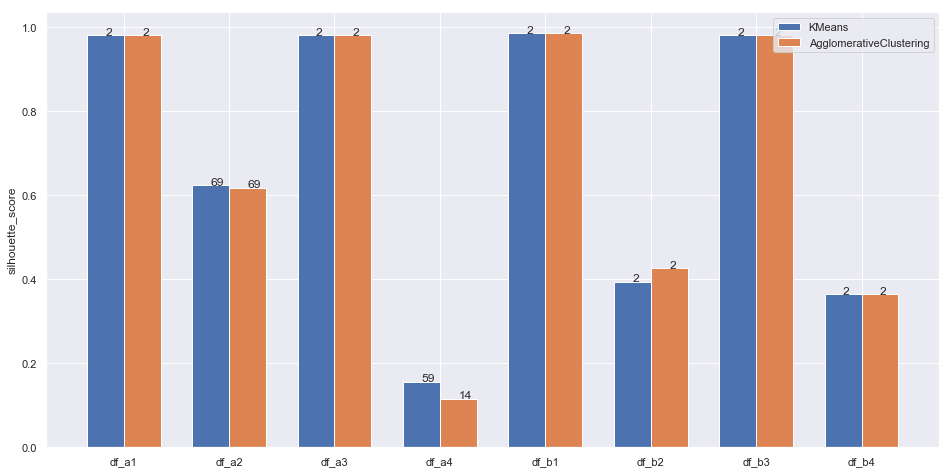

In [118]:

labels = ['df_a1', 'df_a2', 'df_a3', 'df_a4', 'df_b1', 'df_b2', 'df_b3', 'df_b4']
s = [optimal_silhouette_score_km_a1, optimal_silhouette_score_km_a2, optimal_number_clusters_km_a3[0], optimal_number_clusters_km_a4[0]]

sil_km_bar = [optimal_silhouette_score_km_a1, optimal_silhouette_score_km_a2, optimal_number_clusters_km_a3[0], optimal_number_clusters_km_a4[0], optimal_silhouette_score_km_b1, optimal_silhouette_score_km_b2, optimal_number_clusters_km_b3[0], optimal_number_clusters_km_b4[0]]

number_clusters_km_bar = [optimal_number_clusters_km_a1, optimal_number_clusters_km_a2, optimal_number_clusters_km_a3[1], optimal_number_clusters_km_a4[1], optimal_number_clusters_km_b1, optimal_number_clusters_km_b2, optimal_number_clusters_km_b3[1], optimal_number_clusters_km_b4[1]]

sil_agg_bar = [optimal_silhouette_score_agg_a1, optimal_silhouette_score_agg_a2, optimal_number_clusters_agg_a3[0], optimal_number_clusters_agg_a4[0], optimal_silhouette_score_agg_b1, optimal_silhouette_score_agg_b2, optimal_number_clusters_agg_b3[0], optimal_number_clusters_agg_b4[0]]

number_clusters_agg_bar = [optimal_number_clusters_agg_a1, optimal_number_clusters_agg_a2, optimal_number_clusters_agg_a3[1], optimal_number_clusters_agg_a4[1], optimal_number_clusters_agg_b1, optimal_number_clusters_agg_b2, optimal_number_clusters_agg_b3[1], optimal_number_clusters_agg_b4[1]]

x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, sil_km_bar, width, label='KMeans')
rects2 = ax.bar(x + width/2, sil_agg_bar, width, label='AgglomerativeClustering')
ax.set_ylabel('silhouette_score')
ax.set_xticks(x)
ax.set_xticklabels(labels)

for i in x:
    plt.annotate(s='{}'.format(number_clusters_km_bar[i]),
             xy=(i - width/2, sil_km_bar[i] + 0.0005))

    plt.annotate(s='{}'.format(number_clusters_agg_bar[i]),
             xy=(i + width/2, sil_agg_bar[i] + 0.0005))
ax.legend()
plt.show()

### Вывод
MinMaxScaler df_a:
    <br>df_a1 -- > + PF, + PCA.
    <br>df_a2 -- > + PCA, - PF.
    <br>df_a3 -- > + PF, - PCA.
    <br>df_a4 -- > - PF, -PCA.

StandartScaler df_b:
    <br>df_b1 -- > + PF, + PCA.
    <br>df_b2 -- > + PCA, - PF.
    <br>df_b3 -- > + PF, - PCA.
    <br>df_b4 -- > - PF, -PCA.

n_clusters = 2

df_a1 Kmeans, silhouette_score = 0.9807337819071539, 

df_a1 AgglomerativeClustering, silhouette_score = 0.9807337819071539

df_a3 Kmeans, silhouette_score = 0.9807337819071539

df_a3 AgglomerativeClustering, silhouette_score = 0.9807337819071539

df_b1 Kmeans silhouette_score = 0.9852668124695232

df_b1 AgglomerativeClustering, silhouette_score = 0.9852668124695232

df_b3 Kmeans silhouette_score = 0.9807337819071539

df_b3 AgglomerativeClustering, silhouette_score = 0.9807337819071539


**Далее я буду использовать df_b1**

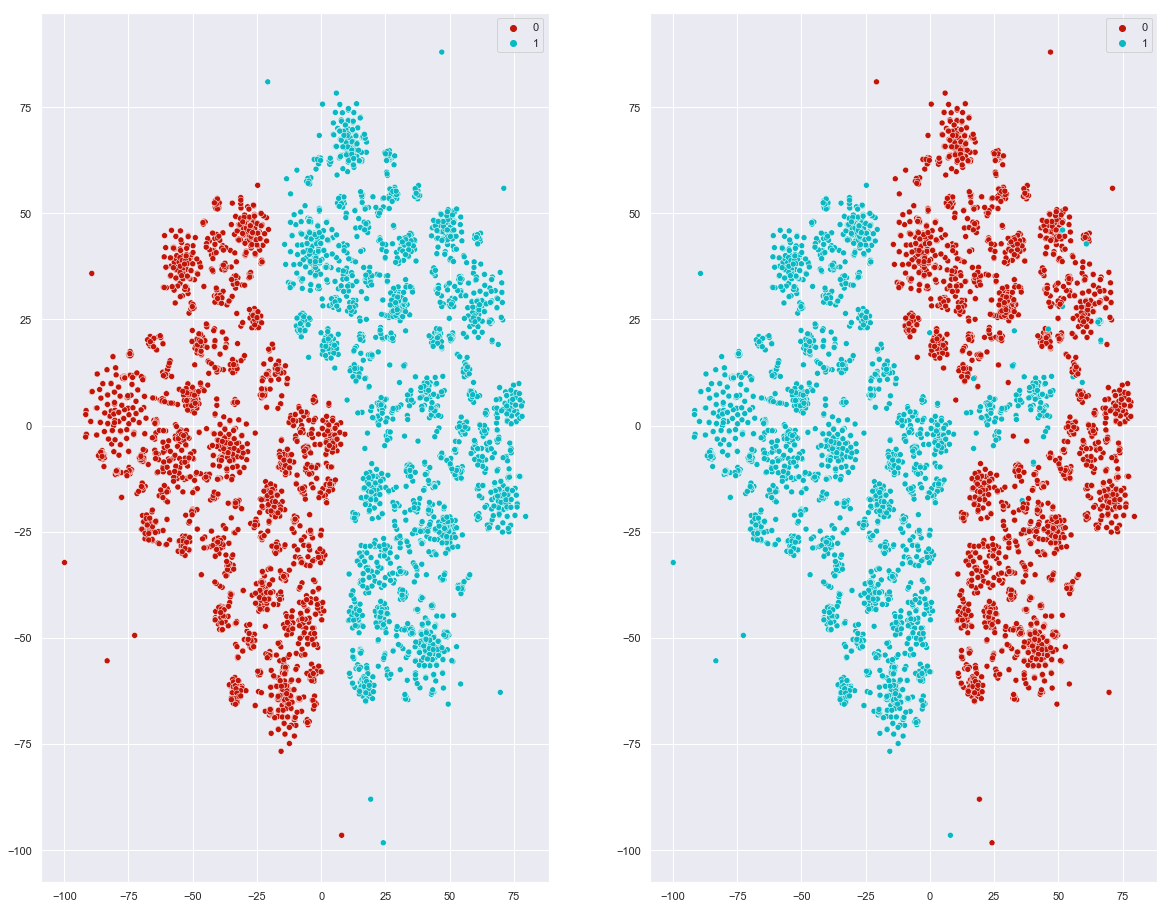

In [162]:
fig, ax = plt.subplots(nrows=1, ncols=2)
sns.set(rc={'figure.figsize':(20,16)})

# PCA
pca = PCA(n_components=10)
pca.fit(df_a2)
df_pca = pca.transform(df_a2)

# tsne
from sklearn.manifold import TSNE
tsne_a = TSNE()
df_tsne = tsne_a.fit_transform(df_a2)

# KMeans
# predicting
km = KMeans(n_clusters=2)
predict_km = km.fit_predict(df_pca)

# AgglomerativeClustering
# predicting
agg = AgglomerativeClustering(n_clusters=2)
predict_agg = agg.fit_predict(df_pca)

palette = sns.hls_palette(km.n_clusters, l=.4, s=.9)
sns.scatterplot(x=df_tsne[:, 0], y=df_tsne[:, 1],
                hue=predict_km, ax=ax[0], palette=palette)
# ax[0].set_title(label='{name_alg} number_cluster = {n}'.format(name_alg='A:  KMeans', n=km_a.n_clusters))

palette = sns.hls_palette(agg.n_clusters, l=.4, s=.9)
sns.scatterplot(x=df_tsne[:, 0], y=df_tsne[:, 1],
                hue=predict_agg, ax=ax[1], palette=palette);
# ax[1].set_title(label='{name_alg} number_cluster = {n}'.format(name_alg='A:  AgglomerativeClustering', n=km_a.n_clusters));

### Поиск оптимального числа класетров

`optimal_number_components_km`, `optimal_number_components_agg` это оптимальное число компанент для PCA
<br>`df_pca` это df к которому было применено pca с оптимальным число компанент
<br> задача, которая стоит сейчас это определить число кластеров

In [64]:
optimal_number_components_agg_a, optimal_number_components_agg_b, optimal_number_components_km_a, optimal_number_components_km_b

(10, 10, 10, 10)

In [65]:
# silhouette_score_km_a = []
# silhouette_score_agg_a = []
# silhouette_score_km_b = []
# silhouette_score_agg_b = []
# for i in range(70, 350):
#     silhouette_score_km_a.append((silhouette_score(X=df_pca_a,
#                                                  labels=KMeans(n_clusters=i).fit_predict(df_pca_a)), i)) 
#     silhouette_score_agg_a.append((silhouette_score(X=df_pca_a,
#                                                   labels=AgglomerativeClustering(n_clusters=i).fit_predict(df_pca_a)), i))
                                                  
#     silhouette_score_km_b.append((silhouette_score(X=df_pca_b,
#                                                  labels=KMeans(n_clusters=i).fit_predict(df_pca_b)), i)) 
#     silhouette_score_agg_b.append((silhouette_score(X=df_pca_b,
#                                                   labels=AgglomerativeClustering(n_clusters=i).fit_predict(df_pca_b)), i))

In [156]:
# sns.set(rc={'figure.figsize':(10,10)})

# # KMeans A
# plot_km_y_a, plot_km_x_a = [i[0] for i in silhouette_score_km_a], [i[1] for i in silhouette_score_km_a]
# plt.plot(plot_km_x_a, plot_km_y_a, label='A:  KMeans')

# # KMeans B
# plot_km_y_b, plot_km_x_b = [i[0] for i in silhouette_score_km_b], [i[1] for i in silhouette_score_km_b]
# plt.plot(plot_km_x_b, plot_km_y_b, label='B:  KMeans')

# # AgglomerativeClustering A
# plot_agg_y_a, plot_agg_x_a = [i[0] for i in silhouette_score_agg_a], [i[1] for i in silhouette_score_agg_a]
# plt.plot(plot_agg_x_a, plot_agg_y_a, label='A:  AgglomerativeClustering')

# # AgglomerativeClustering B
# plot_agg_y_b, plot_agg_x_b = [i[0] for i in silhouette_score_agg_b], [i[1] for i in silhouette_score_agg_b]
# plt.plot(plot_agg_x_b, plot_agg_y_b, label='B:  AgglomerativeClustering')

# # максимальное значение silhouette_score 
# optimal_number_clusters_km_a = max(silhouette_score_km_a)
# optimal_number_clusters_agg_a = max(silhouette_score_agg_a)
# optimal_number_clusters_km_b = max(silhouette_score_km_b)
# optimal_number_clusters_agg_b = max(silhouette_score_agg_b)


# # метка максимума KMeans A
# plt.scatter(x=optimal_number_clusters_km_a[1], y=optimal_number_clusters_km_a[0], marker='x', c='r')
# plt.annotate(s='{label1} - A: KMeans'.format(label1=optimal_number_clusters_km_a[1]),
#              xy=(optimal_number_clusters_km_a[1] + 0.05, optimal_number_clusters_km_a[0] + 0.0005))

# # метка максимума KMeans B
# plt.scatter(x=optimal_number_clusters_km_b[1], y=optimal_number_clusters_km_b[0], marker='o', c='g')
# plt.annotate(s='{label1} - B: KMeans'.format(label1=optimal_number_clusters_km_b[1]),
#              xy=(optimal_number_clusters_km_b[1] + 0.05, optimal_number_clusters_km_b[0] + 0.0005))

# # метка максимума AgglomerativeClustering A
# plt.scatter(x=optimal_number_clusters_agg_a[1], y=optimal_number_clusters_agg_a[0], marker='x', c='y')
# plt.annotate(s='{label1} - A: AgglomerativeCl'.format(label1=optimal_number_clusters_agg_a[1]),
#              xy=(optimal_number_clusters_agg_a[1] + 0.05, optimal_number_clusters_agg_a[0] + 0.0005))

# # метка максимума AgglomerativeClustering B
# plt.scatter(x=optimal_number_clusters_agg_b[1], y=optimal_number_clusters_agg_b[0], marker='o', c='b')
# plt.annotate(s='{label1} - B: AgglomerativeCl'.format(label1=optimal_number_clusters_agg_b[1]),
#              xy=(optimal_number_clusters_agg_b[1] + 0.05, optimal_number_clusters_agg_b[0] + 0.0005))

# plt.xlabel("n_clusters");
# plt.ylabel("Silhouette");
# plt.title('silhouette_score в зависимости от числа компанент')
# plt.legend(['A:  KMeans', 'B:  KMeans', 'A:  AgglomerativeClustering', 'B:  AgglomerativeClustering', 
# f'KMeans A, silhouette{optimal_number_clusters_km_a}',
# f'KMeans B, silhouette{optimal_number_clusters_km_b}',
# f'AggC A, silhouette{optimal_number_clusters_agg_a}',
# f'AggC B, silhouette{optimal_number_clusters_agg_b}']);

In [68]:
# # выберу из 4 вариантов самый оптимальный - те с самой высокой метрикой
# optimal_number_clusters = max(optimal_number_clusters_agg_a, optimal_number_clusters_km_a, optimal_number_clusters_agg_b, optimal_number_clusters_km_b)[1]

In [157]:
# # predicting AgglomerativeClustering n_clusters = 280
# agg = AgglomerativeClustering(n_clusters=optimal_number_clusters)
# predict_agg_clusters_100 = agg.fit_predict(df_pca_b)

# # визуализация
# palette = sns.hls_palette(agg.n_clusters, l=.4, s=.9)
# sns.scatterplot(x=df_tsne_b[:, 0], y=df_tsne_b[:, 1],
#                 hue=predict_agg_clusters_100, palette=palette, legend=False)
# plt.title(label='{name_alg} number_cluster = {n}'.format(name_alg='AgglomerativeClustering', n=agg.n_clusters));

### Клинский профиль

In [153]:
normal_data_and_predict = normal_data_presentation_df_5000.copy()

normal_data_and_predict['predict_agg'] = predict_km

dictionary_function={
    # 'open_account_flg': lambda x: x.value_counts().idxmax(),
                     'gender': lambda x: x.value_counts().idxmax(),
                     'age': np.mean,
                     'marital_status': lambda x: x.value_counts().idxmax(),
                     'job_position':lambda x: x.value_counts().idxmax(),
                     'credit_sum': np.mean,
                     'credit_month': np.median,
                     'tariff_id': lambda x: x.value_counts().idxmax(),
                     'score_shk': np.mean,
                     'education': lambda x: x.value_counts().idxmax(),
                     'living_region': lambda x: x.value_counts().idxmax(),
                     'monthly_income': np.mean,
                     'credit_count': lambda x: x.value_counts().idxmax(),
                     'overdue_credit_count': lambda x: x.value_counts().idxmax()}
                     
client_profile_agg = normal_data_and_predict.groupby(['predict_agg', 'open_account_flg']).agg(dictionary_function)

In [154]:
client_profile_agg

gender        age marital_status job_position  \
predict_agg open_account_flg                                                 
0           0                     M  35.297247            MAR          SPC   
            1                     M  33.557927            MAR          SPC   
1           0                     F  38.078303            MAR          SPC   
            1                     F  37.675127            MAR          SPC   

                                credit_sum  credit_month  tariff_id  \
predict_agg open_account_flg                                          
0           0                 27437.353888            10        1.1   
            1                 24670.581753            10        1.1   
1           0                 26061.150020            10        1.1   
            1                 22453.298663            10        1.1   

                              score_shk education  living_region  \
predict_agg open_account_flg                                       
0           0                  0.456649       SCH     МОСКОВСКАЯ   
            1                  0.495852       SCH     МОСКОВСКАЯ   
1           0                  0.468751       SCH     МОСКОВСКАЯ   
            1                  0.478038       SCH  КРАСНОДАРСКИЙ   

                              monthly_income  credit_count  \
predict_agg open_account_flg                                 
0           0                   47534.353423           2.0   
            1                   44992.754573           2.0   
1           0                   35248.732790           2.0   
            1                   33085.465313           2.0   

                              overdue_credit_count  
predict_agg open_account_flg                        
0           0                                  0.0  
            1                                  0.0  
1           0                                  0.0  
            1                                  0.0

In [158]:
# # можно посомтреть инфомацию о кластерах, в которых больше всего выдали кредиты
# client_profile_agg[client_profile_agg.open_account_flg == 1]

In [159]:
# # клиентский профиль самого вероятсного получателя кредита
# client_profile_agg[client_profile_agg.open_account_flg == 1].groupby(['gender']).agg(dictionary_function)